In [1]:
#import all libraries
import math 
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
%matplotlib inline

In [2]:
#import all csv files
df_country=pd.read_csv('Country.csv')
df_league=pd.read_csv('League.csv')
df_match=pd.read_csv('Match.csv')
df_player=pd.read_csv('Player.csv')
df_Player_Attributes=pd.read_csv('Player_Attributes.csv')
df_sqlite_sequence=pd.read_csv('sqlite_sequence.csv')
df_Team=pd.read_csv('Team.csv')
df_Team_Attributes=pd.read_csv('Team_Attributes.csv')

In [3]:
#drop duplicated column
df_league.drop('country_id',axis=1,inplace=True)

In [4]:
#merge league and country
df_country_league=pd.merge(df_country, df_league, on="id", how="right")

In [5]:
#rename new df columns
df_country_league.rename(columns = {'ID':'Country_ID','name_x':'Country', 'name_y':'League'}, inplace = True)

In [6]:
#drop duplicated column
df_player.drop('id',axis=1,inplace=True)

In [7]:
#merge players and player attributes dfs
df_players_merged=pd.merge(df_Player_Attributes, df_player, on="player_api_id", how="left")

In [8]:
#drop duplicated column
df_players_merged.drop(['id','player_fifa_api_id_y'],axis=1,inplace=True)

In [9]:
#rename new df columns
df_players_merged.rename(columns = {'player_fifa_api_id_x':'player_fifa_api_id'},inplace=True)

In [10]:
#drop duplicated column
df_Team.drop('id',axis=1,inplace=True)

In [11]:
#drop duplicated column
df_Team_Attributes.drop('id',axis=1,inplace=True)

In [12]:
#merge teams and team attributes dfs
df_teams_merged=pd.merge(df_Team_Attributes, df_Team, on="team_api_id", how="left")

In [13]:
#rename columns
df_teams_merged.drop('team_fifa_api_id_y',axis=1,inplace=True)
df_teams_merged.rename(columns = {'team_fifa_api_id_x':'team_fifa_api_id'},inplace=True)

In [14]:
#change date column to datetime format
df_teams_merged['date']=pd.to_datetime(df_teams_merged['date'])
df_players_merged['date']=pd.to_datetime(df_players_merged['date'])

In [15]:
#fixing buildUpPlayDribblingClass null data using mean result from teams with '"Little" buildUpPlayDribblingClass'
buildUpPlayDribblingClass_little=df_teams_merged.query('buildUpPlayDribblingClass=="Little"').buildUpPlayDribbling

In [16]:
buildUpPlayDribbling_nan=df_teams_merged[df_teams_merged['buildUpPlayDribbling'].isna()]
buildUpPlayDribbling_not_nan=df_teams_merged[df_teams_merged['buildUpPlayDribbling'].notna()]

In [17]:
little_buildUpPlayDribbling_mean=buildUpPlayDribbling_not_nan.query('buildUpPlayDribblingClass=="Little"').buildUpPlayDribbling.mean()

In [18]:
df_teams_merged['buildUpPlayDribbling'].fillna(round(little_buildUpPlayDribbling_mean),inplace=True)

In [19]:
df_teams_merged["buildUpPlayDribbling"]=df_teams_merged["buildUpPlayDribbling"].astype(int)

In [20]:
#display info for debugging purposes
df_players_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183978 entries, 0 to 183977
Data columns (total 45 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   player_fifa_api_id   183978 non-null  int64         
 1   player_api_id        183978 non-null  int64         
 2   date                 183978 non-null  datetime64[ns]
 3   overall_rating       183142 non-null  float64       
 4   potential            183142 non-null  float64       
 5   preferred_foot       183142 non-null  object        
 6   attacking_work_rate  180748 non-null  object        
 7   defensive_work_rate  183142 non-null  object        
 8   crossing             183142 non-null  float64       
 9   finishing            183142 non-null  float64       
 10  heading_accuracy     183142 non-null  float64       
 11  short_passing        183142 non-null  float64       
 12  volleys              181265 non-null  float64       
 13  dribbling     

In [21]:
# numerical stats that hav null values
stats_num_na=['overall_rating','potential','crossing','finishing','heading_accuracy',
'short_passing','volleys','dribbling','curve','free_kick_accuracy','long_passing','ball_control',
'acceleration','sprint_speed','agility','reactions','balance','shot_power','jumping','stamina','strength',
'long_shots','aggression','interceptions','positioning','vision','penalties','marking','standing_tackle',
'sliding_tackle','gk_diving','gk_handling','gk_kicking','gk_positioning','gk_reflexes']

In [22]:
#fixing numerical stats by getting mean result of one year before and one year after if available
j=0
for stat in stats_num_na:
    i=0
    testing=df_players_merged[df_players_merged[stats_num_na[j]].isna()]
    stat_player_fifa_api_id_na=df_players_merged[df_players_merged[stats_num_na[j]].isna()].player_fifa_api_id
    df_player_indexes=stat_player_fifa_api_id_na.index
    for player_api_id in stat_player_fifa_api_id_na:
        if df_player_indexes[i] in df_players_merged.query('player_fifa_api_id==@player_api_id').index[1:-2]:
            player_index=df_player_indexes[i]
            mean_2_year_rating=((df_players_merged.loc[player_index-1][stats_num_na[j]])+(df_players_merged.loc[player_index+1][stats_num_na[j]]))/2
            df_players_merged.loc[player_index, stats_num_na[j]]=mean_2_year_rating
        elif df_player_indexes[i] == df_players_merged.query('player_fifa_api_id==@player_api_id').index[0]:
            player_index=df_player_indexes[i]
            next_year_rating=df_players_merged.loc[player_index+1][stats_num_na[j]]
            df_players_merged.loc[player_index, stats_num_na[j]]=next_year_rating
        elif df_player_indexes[i] == df_players_merged.query('player_fifa_api_id==@player_api_id').index[-1]:
            player_index=df_player_indexes[i]
            next_year_rating=df_players_merged.loc[player_index-1][stats_num_na[j]]
            df_players_merged.loc[player_index, stats_num_na[j]]=next_year_rating
        i=i+1
    j+=1

In [23]:
#display info for debugging purposes
df_players_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183978 entries, 0 to 183977
Data columns (total 45 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   player_fifa_api_id   183978 non-null  int64         
 1   player_api_id        183978 non-null  int64         
 2   date                 183978 non-null  datetime64[ns]
 3   overall_rating       183901 non-null  float64       
 4   potential            183901 non-null  float64       
 5   preferred_foot       183142 non-null  object        
 6   attacking_work_rate  180748 non-null  object        
 7   defensive_work_rate  183142 non-null  object        
 8   crossing             183901 non-null  float64       
 9   finishing            183901 non-null  float64       
 10  heading_accuracy     183901 non-null  float64       
 11  short_passing        183901 non-null  float64       
 12  volleys              181975 non-null  float64       
 13  dribbling     

In [24]:
#string stats that have null values
stats_str_na=['preferred_foot','attacking_work_rate','defensive_work_rate']

In [25]:
#fixing string stats by getting mean result of one year before and one year after if available
j=0
for stat in stats_str_na:
    i=0
    testing=df_players_merged[df_players_merged[stats_str_na[j]].isna()]
    stat_player_fifa_api_id_na=df_players_merged[df_players_merged[stats_str_na[j]].isna()].player_fifa_api_id
    df_player_indexes=stat_player_fifa_api_id_na.index
    for player_api_id in stat_player_fifa_api_id_na:
        if df_player_indexes[i] in df_players_merged.query('player_fifa_api_id==@player_api_id').index[1:-1]:
            player_index=df_player_indexes[i]
            next_year_rating=df_players_merged.loc[player_index-1][stats_str_na[j]]
            df_players_merged.loc[player_index, stats_str_na[j]]=next_year_rating
        elif df_player_indexes[i] == df_players_merged.query('player_fifa_api_id==@player_api_id').index[0]:
            player_index=df_player_indexes[i]
            next_year_rating=df_players_merged.loc[player_index+1][stats_str_na[j]]
            df_players_merged.loc[player_index, stats_str_na[j]]=next_year_rating
        i=i+1
    j+=1

In [26]:
#display info for debugging purposes
df_players_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183978 entries, 0 to 183977
Data columns (total 45 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   player_fifa_api_id   183978 non-null  int64         
 1   player_api_id        183978 non-null  int64         
 2   date                 183978 non-null  datetime64[ns]
 3   overall_rating       183901 non-null  float64       
 4   potential            183901 non-null  float64       
 5   preferred_foot       183200 non-null  object        
 6   attacking_work_rate  180806 non-null  object        
 7   defensive_work_rate  183200 non-null  object        
 8   crossing             183901 non-null  float64       
 9   finishing            183901 non-null  float64       
 10  heading_accuracy     183901 non-null  float64       
 11  short_passing        183901 non-null  float64       
 12  volleys              181975 non-null  float64       
 13  dribbling     

In [27]:
#drop null rows with numerical values
df_players_merged.dropna(subset=stats_num_na, inplace=True)

In [28]:
#fill null values that have not been replaced or dropped
df_players_merged['attacking_work_rate'].fillna('None', inplace=True)
df_players_merged['defensive_work_rate'].fillna('0', inplace=True)
df_players_merged['preferred_foot'].fillna('Unspecified', inplace=True)

In [29]:
#change date column to datetime format
df_match['date']=pd.to_datetime(df_match['date'])
#all null removed from match df
df_match_no_null=df_match.dropna()
#null in player cordinates or api's removed from match df
columns_players=df_match.columns[11:77]
df_match_Players_no_null=df_match
for column in columns_players:
    df_match_Players_no_null = df_match_Players_no_null[df_match_Players_no_null[column].notna()]
    df_match_Players_no_null.reset_index(drop=True,inplace=True)
#null in coord only removed from match df
columns1=list(df_match.columns[12:22])
columns2=list(df_match.columns[23:33])
columns3=list(df_match.columns[34:44])
columns4=list(df_match.columns[45:55])
columns_players=columns1+columns2+columns3+columns4
df_match_Coord_no_null=df_match
for column in columns_players:
    df_match_Coord_no_null = df_match_Coord_no_null[df_match_Coord_no_null[column].notna()]
    df_match_Coord_no_null.reset_index(drop=True,inplace=True)
#-------------------------------------------------------------------------------------------------------------------------#

In [174]:
#pick match api id to display formation (Enter Below)
def Formation_Visualisation(match_api_id_picked):
    #match_api_id_picked=(((493045)))
    picked_match=df_match_Players_no_null.query('match_api_id==@match_api_id_picked')
    picked_match_index=picked_match.index
    picked_match_index=picked_match_index[0]
    match_dat=df_match_Players_no_null.iloc[picked_match_index][5]
    match_ply=df_match_Players_no_null.iloc[picked_match_index][11:77]
    match_nam=df_match_Players_no_null.iloc[picked_match_index][7:9]
    player_names=[]
    for playersID in match_ply[44:66]:
        player_names.append(df_player.query('player_api_id==@playersID').iloc[0].player_name)
    match_players=pd.DataFrame(player_names,columns=['Name'])
    match_players['X_coordinate']=match_ply[0:22]
    match_players['X_coordinate'][0:22]=match_ply[0:22]
    match_players['Y_coordinate']=match_ply[22:44]
    match_players['Y_coordinate'][0:22]=match_ply[22:44]
    Home_Team_nam=df_teams_merged.query('team_api_id==@match_nam[0]').team_long_name
    Away_Team_nam=df_teams_merged.query('team_api_id==@match_nam[1]').team_long_name
    Home_Team_nam=Home_Team_nam.iloc[0]
    Away_Team_nam=Away_Team_nam.iloc[0]
    # creating graph space for two graphs
    Formation, (plot1, plot2) = plt.subplots(2,figsize=(14,14))
    Formation.patch.set_facecolor((0.4, 0.9, 0.4))
    plt.title('Match Formation', y=2.27, fontsize=18)
    # adjust goalkeeper positions
    match_players.X_coordinate[0]=5
    match_players.X_coordinate[11]=5
    # plot1 graph for away team
    plot1.scatter(match_players.X_coordinate[11:22], (match_players.Y_coordinate[11:22]),color='red',s=100,marker="^",label=Away_Team_nam)
    #plot1.set_title("Away Team")
    i=0
    for points in match_players.X_coordinate[11:22]:
          plot1.text((match_players.X_coordinate[i+11]+0.2),(match_players.Y_coordinate[i+11]-0.5),match_players.Name[i+11])
          i+=1
    plot1.invert_xaxis()
    plot1.invert_yaxis()
    plot1.set_facecolor((0.4, 0.9, 0.4))
    plot1.get_xaxis().set_visible(False)
    plot1.get_yaxis().set_visible(False)
    # plot2 graph for home team
    plot2.scatter(match_players.X_coordinate[0:11], (match_players.Y_coordinate[0:11]),color='blue',s=100,marker="^",label=Home_Team_nam)
    #plot2.set_title("Home Team")
    i=0
    for points in match_players.X_coordinate[0:11]:
           plot2.text((match_players.X_coordinate[i]+0.2),(match_players.Y_coordinate[i]+0.5),match_players.Name[i])
           i+=1
    plot2.invert_xaxis()
    plot2.set_facecolor((0.4, 0.9, 0.4))
    plot2.get_xaxis().set_visible(False)
    plot2.get_yaxis().set_visible(False)
    # display the graph
    #graph.tight_layout()
    Formation.legend(bbox_to_anchor=(1, 0.5),loc="right")
    plt.show()
    
    

In [175]:
match_players

,Name,X_coordinate,Y_coordinate
0,Bojan Jorgacevic,5,1.0
1,Dario Smoje,2.0,3.0
2,Jonas De Roeck,4.0,3.0
3,Kenny Thompson,6.0,3.0
4,Roberto Rosales,8.0,3.0
5,Tim Smolders,2.0,7.0
6,Christophe Grondin,4.0,7.0
7,Milos Maric,6.0,7.0
8,Bryan Ruiz,8.0,7.0
9,Adnan Custovic,4.0,10.0


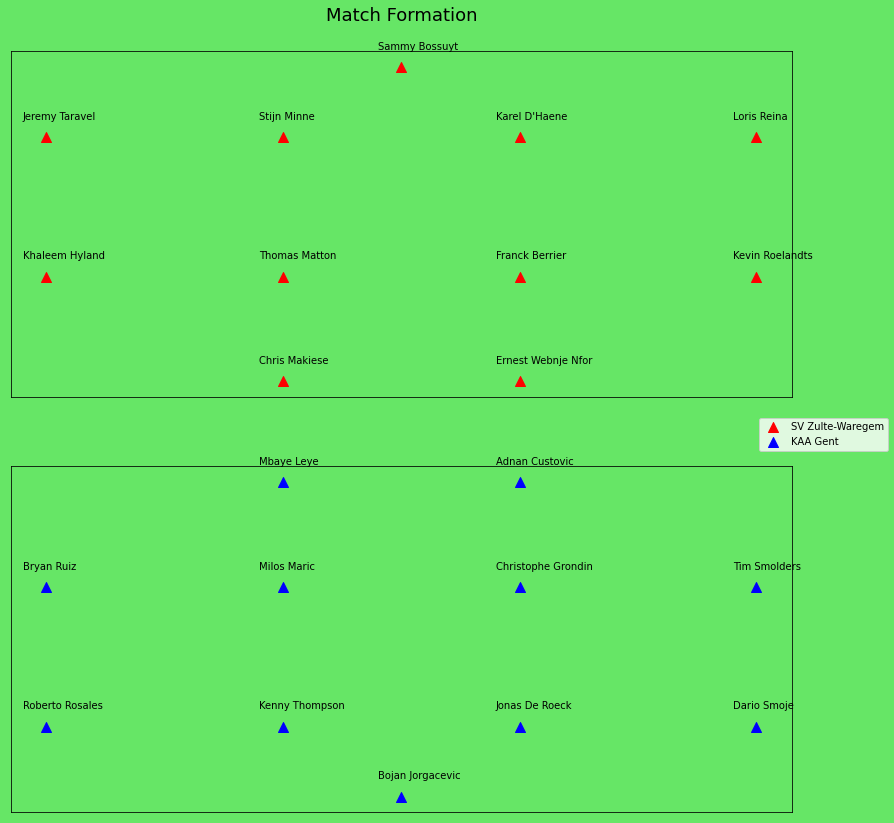

In [176]:
Formation_Visualisation(493045)

In [152]:
#add home and away home team formations to df
df_match_Coord_no_null["Home_team_formation"] = np.nan
df_match_Coord_no_null["Away_team_formation"] = np.nan
for matches in df_match_Coord_no_null.index:
    temp1=list(df_match_Coord_no_null.iloc[matches][34:44].value_counts())   
    df_match_Coord_no_null.Home_team_formation.iloc[matches]=str(temp1)
    temp2=list(df_match_Coord_no_null.iloc[matches][45:55].value_counts())
    df_match_Coord_no_null.Away_team_formation.iloc[matches]=str(temp2)

C:\Users\mrkim\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [183]:
#display columns with stats for debugging purposes
i=0
for x in df_match.columns: 
    print(x+':', (df_match.iloc[145][i]))
    i+=1

id: 146
country_id: 1
league_id: 1
season: 2008/2009
stage: 24
date: 2009-02-27 00:00:00
match_api_id: 493017
home_team_api_id: 8203
away_team_api_id: 9987
home_team_goal: 2
away_team_goal: 1
home_player_X1: 1.0
home_player_X2: 2.0
home_player_X3: 4.0
home_player_X4: 6.0
home_player_X5: 8.0
home_player_X6: 2.0
home_player_X7: 4.0
home_player_X8: 6.0
home_player_X9: 8.0
home_player_X10: 4.0
home_player_X11: 6.0
away_player_X1: 1.0
away_player_X2: 2.0
away_player_X3: 4.0
away_player_X4: 6.0
away_player_X5: 8.0
away_player_X6: 2.0
away_player_X7: 4.0
away_player_X8: 6.0
away_player_X9: 8.0
away_player_X10: 4.0
away_player_X11: 6.0
home_player_Y1: 1.0
home_player_Y2: 3.0
home_player_Y3: 3.0
home_player_Y4: 3.0
home_player_Y5: 3.0
home_player_Y6: 7.0
home_player_Y7: 7.0
home_player_Y8: 7.0
home_player_Y9: 7.0
home_player_Y10: 10.0
home_player_Y11: 10.0
away_player_Y1: 1.0
away_player_Y2: 3.0
away_player_Y3: 3.0
away_player_Y4: 3.0
away_player_Y5: 3.0
away_player_Y6: 7.0
away_player_Y7: 7.0


In [177]:
#calculates and plots formations with highest winning chances
Winning_formations=[]
for matches in df_match_Coord_no_null.index:
    if df_match_Coord_no_null.home_team_goal[matches]==df_match_Coord_no_null.away_team_goal[matches]:
        continue
    elif df_match_Coord_no_null.home_team_goal[matches]>df_match_Coord_no_null.away_team_goal[matches]:
        Winning_formations.append(df_match_Coord_no_null.Home_team_formation[matches])
    elif df_match_Coord_no_null.home_team_goal[matches]<df_match_Coord_no_null.away_team_goal[matches]:
        Winning_formations.append(df_match_Coord_no_null.Away_team_formation[matches])  

In [178]:
df_Winning_formations = pd.DataFrame(Winning_formations)

In [179]:
df_Winning_formations.columns=['Win_Form']

In [180]:
#Heights=df_Winning_formations.value_counts()
Heights=df_Winning_formations.value_counts()*100/(df_match_Coord_no_null.query('home_team_goal!=away_team_goal').shape[0])

Text(0, 0.5, 'Percent of winning chances')

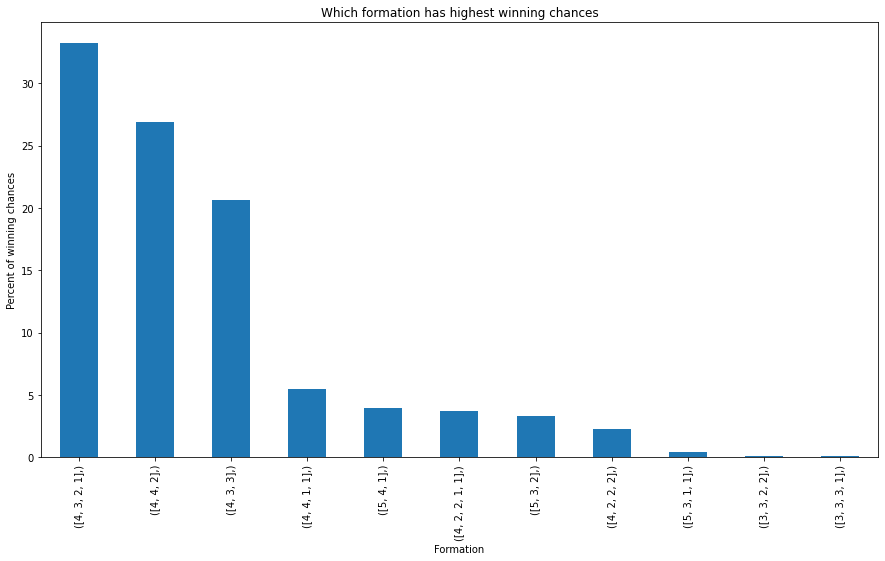

In [181]:
Heights.plot(kind='bar',figsize=(15,8));
plt.title("Which formation has highest winning chances")
plt.xlabel("Formation")
plt.ylabel("Percent of winning chances")

In [46]:
#calculates if possession affects chances of winning
higher_possession_won=[]
for matches in df_match.possession.dropna().reset_index().index:
    try:
        pos_data=df_match.possession.dropna().reset_index().iloc[matches]
        soup = BeautifulSoup(pos_data[1], "html.parser")  
        awaypos=soup.find_all('awaypos')[-1].contents[0]
        homepos=soup.find_all('homepos')[-1].contents[0]
        if awaypos==homepos:
            continue
        elif df_match[df_match['possession'].notna()]['home_team_goal'].reset_index().iloc[matches][1]==df_match[df_match['possession'].notna()]['away_team_goal'].reset_index().iloc[matches][1]:
            continue
        elif awaypos>homepos:
            if df_match[df_match['possession'].notna()]['home_team_goal'].reset_index().iloc[matches][1]<df_match[df_match['possession'].notna()]['away_team_goal'].reset_index().iloc[matches][1]:
                higher_possession_won.append('Yes')
            elif df_match[df_match['possession'].notna()]['home_team_goal'].reset_index().iloc[matches][1]>df_match[df_match['possession'].notna()]['away_team_goal'].reset_index().iloc[matches][1]:
                higher_possession_won.append('No')
        elif awaypos<homepos:
            if df_match[df_match['possession'].notna()]['home_team_goal'].reset_index().iloc[matches][1]>df_match[df_match['possession'].notna()]['away_team_goal'].reset_index().iloc[matches][1]:
                higher_possession_won.append('Yes')
            elif df_match[df_match['possession'].notna()]['home_team_goal'].reset_index().iloc[matches][1]<df_match[df_match['possession'].notna()]['away_team_goal'].reset_index().iloc[matches][1]:
                higher_possession_won.append('No')
    except:
        continue

In [47]:
df_higher_possession_won = pd.DataFrame(higher_possession_won)
df_higher_possession_won.columns=['Won?']

In [48]:
df_higher_possession_won.value_counts()

Won?
Yes     3612
No      2453
dtype: int64

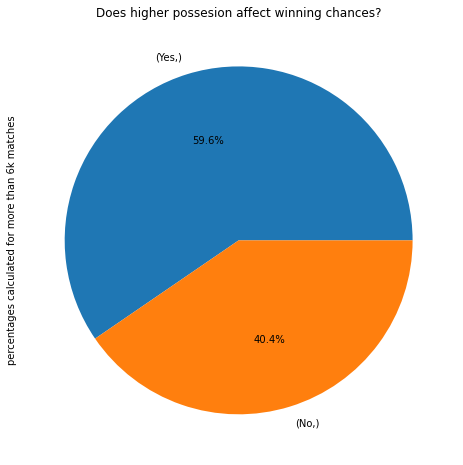

In [49]:
df_higher_possession_won.value_counts().plot(kind='pie',figsize=(15,8),autopct='%0.1f%%');
plt.title("Does higher possesion affect winning chances?");
plt.ylabel("percentages calculated for more than 6k matches");

In [50]:
#Home Team Chances
df_match.query('home_team_goal>away_team_goal').shape[0]/(df_match.query('home_team_goal<away_team_goal').shape[0]+df_match.query('home_team_goal>away_team_goal').shape[0])

0.6148171077748542

In [51]:
#calculates bidding agency with most accurate biddings
df_match.columns[85:115]

Index(['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA',
       'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH',
       'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD',
       'BSA'],
      dtype='object')

In [52]:
columns_players=df_match.columns[85:115]
df_match_Odds_no_null=df_match
for column in columns_players:
    df_match_Odds_no_null = df_match_Odds_no_null[df_match_Odds_no_null[column].notna()]
    df_match_Odds_no_null.reset_index(drop=True,inplace=True)

In [53]:
columns1=list(df_match.columns[9:11])
columns2=list(df_match.columns[85:115])
columns_odds=columns1+columns2
df_match_Odds_no_null[columns_odds]

,home_team_goal,away_team_goal,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,2,4,2.38,3.25,3.00,2.45,3.30,2.70,2.30,3.1,...,2.88,2.40,3.40,2.90,2.45,3.30,2.70,2.40,3.25,2.70
1,5,2,1.80,3.60,4.33,1.75,3.70,4.20,1.80,3.2,...,4.50,1.80,3.60,4.50,1.75,3.70,4.20,1.80,3.50,4.00
2,0,1,1.65,3.80,5.00,1.67,3.60,5.00,1.65,3.3,...,5.50,1.70,3.70,5.00,1.67,3.60,5.00,1.70,3.50,4.50
3,4,2,1.50,4.00,7.00,1.53,3.90,6.00,1.50,3.7,...,6.00,1.57,3.90,6.00,1.53,3.90,6.00,1.50,3.80,6.00
4,3,1,1.29,5.25,10.00,1.25,5.50,10.00,1.25,4.5,...,11.00,1.25,5.50,12.00,1.25,5.50,10.00,1.25,5.50,9.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2751,3,1,2.00,3.40,3.75,2.00,3.20,3.90,1.85,3.5,...,3.80,2.05,3.50,3.90,2.00,3.20,3.90,2.00,3.40,3.50
2752,2,1,3.00,3.25,2.38,3.30,3.20,2.35,2.90,3.3,...,2.38,3.20,3.40,2.38,3.30,3.20,2.35,2.88,3.30,2.38
2753,0,5,8.00,4.50,1.40,8.75,4.75,1.40,7.60,4.8,...,1.33,9.00,5.25,1.36,8.75,4.75,1.40,8.50,4.50,1.36
2754,1,1,1.91,3.50,4.00,1.90,3.40,4.00,2.00,3.3,...,3.80,1.95,3.60,4.20,1.90,3.40,4.00,1.91,3.50,3.75


In [54]:
winning_bids=[]
for matches in df_match_Odds_no_null.index:
    if df_match_Odds_no_null.home_team_goal.iloc[matches]>df_match_Odds_no_null.away_team_goal.iloc[matches]:
        if df_match_Odds_no_null.B365H.iloc[matches]<df_match_Odds_no_null.B365D.iloc[matches] and df_match_Odds_no_null.B365H.iloc[matches]<df_match_Odds_no_null.B365A.iloc[matches]:
            winning_bids.append('B365')
        if df_match_Odds_no_null.BWH.iloc[matches]<df_match_Odds_no_null.BWD.iloc[matches] and df_match_Odds_no_null.BWH.iloc[matches]<df_match_Odds_no_null.BWA.iloc[matches]:
            winning_bids.append('BW')
        if df_match_Odds_no_null.IWH.iloc[matches]<df_match_Odds_no_null.IWD.iloc[matches] and df_match_Odds_no_null.IWH.iloc[matches]<df_match_Odds_no_null.IWA.iloc[matches]:
            winning_bids.append('IW')
        if df_match_Odds_no_null.LBH.iloc[matches]<df_match_Odds_no_null.LBD.iloc[matches] and df_match_Odds_no_null.LBH.iloc[matches]<df_match_Odds_no_null.LBA.iloc[matches]:
            winning_bids.append('LB')
        if df_match_Odds_no_null.PSH.iloc[matches]<df_match_Odds_no_null.PSD.iloc[matches] and df_match_Odds_no_null.PSH.iloc[matches]<df_match_Odds_no_null.PSA.iloc[matches]:
            winning_bids.append('PS')
        if df_match_Odds_no_null.WHH.iloc[matches]<df_match_Odds_no_null.WHD.iloc[matches] and df_match_Odds_no_null.WHH.iloc[matches]<df_match_Odds_no_null.WHA.iloc[matches]:
            winning_bids.append('WH')
        if df_match_Odds_no_null.SJH.iloc[matches]<df_match_Odds_no_null.SJD.iloc[matches] and df_match_Odds_no_null.SJH.iloc[matches]<df_match_Odds_no_null.SJA.iloc[matches]:
            winning_bids.append('SJ')
        if df_match_Odds_no_null.VCH.iloc[matches]<df_match_Odds_no_null.VCD.iloc[matches] and df_match_Odds_no_null.VCH.iloc[matches]<df_match_Odds_no_null.VCA.iloc[matches]:
            winning_bids.append('VC')
        if df_match_Odds_no_null.GBH.iloc[matches]<df_match_Odds_no_null.GBD.iloc[matches] and df_match_Odds_no_null.GBH.iloc[matches]<df_match_Odds_no_null.GBA.iloc[matches]:
            winning_bids.append('GB')
        if df_match_Odds_no_null.BSH.iloc[matches]<df_match_Odds_no_null.BSD.iloc[matches] and df_match_Odds_no_null.BSH.iloc[matches]<df_match_Odds_no_null.BSA.iloc[matches]:
            winning_bids.append('BS')
    elif df_match_Odds_no_null.home_team_goal.iloc[matches]<df_match_Odds_no_null.away_team_goal.iloc[matches]:
        if df_match_Odds_no_null.B365A.iloc[matches]<df_match_Odds_no_null.B365D.iloc[matches] and df_match_Odds_no_null.B365H.iloc[matches]>df_match_Odds_no_null.B365A.iloc[matches]:
            winning_bids.append('B365')
        if df_match_Odds_no_null.BWA.iloc[matches]<df_match_Odds_no_null.BWD.iloc[matches] and df_match_Odds_no_null.BWH.iloc[matches]>df_match_Odds_no_null.BWA.iloc[matches]:
            winning_bids.append('BW')
        if df_match_Odds_no_null.IWA.iloc[matches]<df_match_Odds_no_null.IWD.iloc[matches] and df_match_Odds_no_null.IWH.iloc[matches]>df_match_Odds_no_null.IWA.iloc[matches]:
            winning_bids.append('IW')
        if df_match_Odds_no_null.LBA.iloc[matches]<df_match_Odds_no_null.LBD.iloc[matches] and df_match_Odds_no_null.LBH.iloc[matches]>df_match_Odds_no_null.LBA.iloc[matches]:
            winning_bids.append('LB')
        if df_match_Odds_no_null.PSA.iloc[matches]<df_match_Odds_no_null.PSD.iloc[matches] and df_match_Odds_no_null.PSH.iloc[matches]>df_match_Odds_no_null.PSA.iloc[matches]:
            winning_bids.append('PS')
        if df_match_Odds_no_null.WHA.iloc[matches]<df_match_Odds_no_null.WHD.iloc[matches] and df_match_Odds_no_null.WHH.iloc[matches]>df_match_Odds_no_null.WHA.iloc[matches]:
            winning_bids.append('WH')
        if df_match_Odds_no_null.SJA.iloc[matches]<df_match_Odds_no_null.SJD.iloc[matches] and df_match_Odds_no_null.SJH.iloc[matches]>df_match_Odds_no_null.SJA.iloc[matches]:
            winning_bids.append('SJ')
        if df_match_Odds_no_null.VCA.iloc[matches]<df_match_Odds_no_null.VCD.iloc[matches] and df_match_Odds_no_null.VCH.iloc[matches]>df_match_Odds_no_null.VCA.iloc[matches]:
            winning_bids.append('VC')
        if df_match_Odds_no_null.GBA.iloc[matches]<df_match_Odds_no_null.GBD.iloc[matches] and df_match_Odds_no_null.GBH.iloc[matches]>df_match_Odds_no_null.GBA.iloc[matches]:
            winning_bids.append('GB')
        if df_match_Odds_no_null.BSA.iloc[matches]<df_match_Odds_no_null.BSD.iloc[matches] and df_match_Odds_no_null.BSH.iloc[matches]>df_match_Odds_no_null.BSA.iloc[matches]:
            winning_bids.append('BS')
    elif df_match_Odds_no_null.home_team_goal.iloc[matches]==df_match_Odds_no_null.away_team_goal.iloc[matches]:
        if df_match_Odds_no_null.B365A.iloc[matches]>df_match_Odds_no_null.B365D.iloc[matches] and df_match_Odds_no_null.B365H.iloc[matches]>df_match_Odds_no_null.B365D.iloc[matches]:
            winning_bids.append('B365')
        if df_match_Odds_no_null.BWA.iloc[matches]>df_match_Odds_no_null.BWD.iloc[matches] and df_match_Odds_no_null.BWH.iloc[matches]>df_match_Odds_no_null.BWD.iloc[matches]:
            winning_bids.append('BW')
        if df_match_Odds_no_null.IWA.iloc[matches]>df_match_Odds_no_null.IWD.iloc[matches] and df_match_Odds_no_null.IWH.iloc[matches]>df_match_Odds_no_null.IWD.iloc[matches]:
            winning_bids.append('IW')
        if df_match_Odds_no_null.LBA.iloc[matches]>df_match_Odds_no_null.LBD.iloc[matches] and df_match_Odds_no_null.LBH.iloc[matches]>df_match_Odds_no_null.LBD.iloc[matches]:
            winning_bids.append('LB')
        if df_match_Odds_no_null.PSA.iloc[matches]>df_match_Odds_no_null.PSD.iloc[matches] and df_match_Odds_no_null.PSH.iloc[matches]>df_match_Odds_no_null.PSD.iloc[matches]:
            winning_bids.append('PS')
        if df_match_Odds_no_null.WHA.iloc[matches]>df_match_Odds_no_null.WHD.iloc[matches] and df_match_Odds_no_null.WHH.iloc[matches]>df_match_Odds_no_null.WHD.iloc[matches]:
            winning_bids.append('WH')
        if df_match_Odds_no_null.SJA.iloc[matches]>df_match_Odds_no_null.SJD.iloc[matches] and df_match_Odds_no_null.SJH.iloc[matches]>df_match_Odds_no_null.SJD.iloc[matches]:
            winning_bids.append('SJ')
        if df_match_Odds_no_null.VCA.iloc[matches]>df_match_Odds_no_null.VCD.iloc[matches] and df_match_Odds_no_null.VCH.iloc[matches]>df_match_Odds_no_null.VCD.iloc[matches]:
            winning_bids.append('VC')
        if df_match_Odds_no_null.GBA.iloc[matches]>df_match_Odds_no_null.GBD.iloc[matches] and df_match_Odds_no_null.GBH.iloc[matches]>df_match_Odds_no_null.GBD.iloc[matches]:
            winning_bids.append('GB')
        if df_match_Odds_no_null.BSA.iloc[matches]>df_match_Odds_no_null.BSD.iloc[matches] and df_match_Odds_no_null.BSH.iloc[matches]>df_match_Odds_no_null.BSD.iloc[matches]:
            winning_bids.append('BS')
            

In [55]:
df_winning_bids=pd.DataFrame(winning_bids)

In [56]:
win_bid_list=df_winning_bids.value_counts().index.tolist()
win_bid_list1=[]
for elements in win_bid_list:
    win_bid_list1.append(str(elements).strip('(,)').replace("'",''))

Text(0, 0.5, 'Percent of accurate Bids')

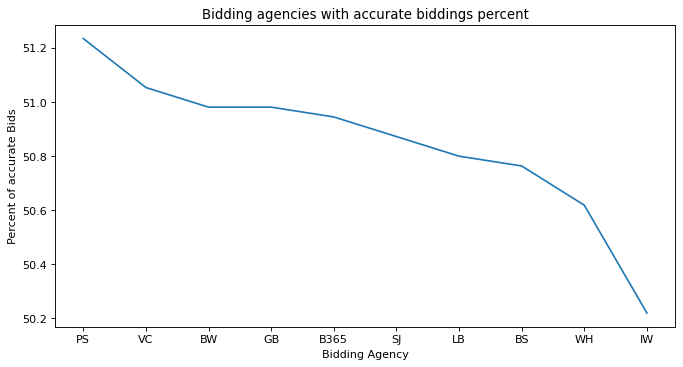

In [57]:
plt.figure(figsize=(10, 5), dpi=80)
plt.plot(win_bid_list1,(list(df_winning_bids.value_counts()*100/(df_match_Odds_no_null.shape[0]))));
plt.title("Bidding agencies with accurate biddings percent")
plt.xlabel("Bidding Agency")
plt.ylabel("Percent of accurate Bids")

In [184]:
df_match.season.value_counts()

2008/2009    3326
2015/2016    3326
2014/2015    3325
2010/2011    3260
2012/2013    3260
2009/2010    3230
2011/2012    3220
2013/2014    3032
Name: season, dtype: int64

In [185]:
#calculates teams with most consistent points per match record across all seasons
#calculates teams with highest difference in points per match record between 2015/2016 season and 2008/2009 season
df_2008_2009=df_match.query('season=="2008/2009"').reset_index(drop=True)
all_matches_played2008_2009=[]
winning_teams2008_2009=[]
for matches in df_2008_2009.index:
    all_matches_played2008_2009.append(df_2008_2009.home_team_api_id.iloc[matches]) 
    all_matches_played2008_2009.append(df_2008_2009.away_team_api_id.iloc[matches])
    if df_2008_2009.home_team_goal.iloc[matches]==df_2008_2009.away_team_goal.iloc[matches]:
        winning_teams2008_2009.append(df_2008_2009.home_team_api_id.iloc[matches])  
        winning_teams2008_2009.append(df_2008_2009.away_team_api_id.iloc[matches])
    elif df_2008_2009.home_team_goal.iloc[matches]>df_2008_2009.away_team_goal.iloc[matches]:
        winning_teams2008_2009.append(df_2008_2009.home_team_api_id.iloc[matches])
        winning_teams2008_2009.append(df_2008_2009.home_team_api_id.iloc[matches])
        winning_teams2008_2009.append(df_2008_2009.home_team_api_id.iloc[matches])
    elif df_2008_2009.home_team_goal.iloc[matches]<df_2008_2009.away_team_goal.iloc[matches]:
        winning_teams2008_2009.append(df_2008_2009.away_team_api_id.iloc[matches])
        winning_teams2008_2009.append(df_2008_2009.away_team_api_id.iloc[matches])
        winning_teams2008_2009.append(df_2008_2009.away_team_api_id.iloc[matches])
        

In [186]:
df_winning_teams2008_2009=pd.DataFrame(winning_teams2008_2009)
df_winning_teams2008_2009_list=df_winning_teams2008_2009.value_counts().index.tolist()
df_winning_teams2008_2009_index=[]
for elements in df_winning_teams2008_2009_list:
    df_winning_teams2008_2009_index.append(str(elements).strip(',)( '))
df_winning_teams2008_2009_VC=pd.DataFrame(df_winning_teams2008_2009.value_counts()).reset_index(drop=True)
df_winning_teams2008_2009_VC.columns=['No_of_Points_2008_2009']
df_winning_teams2008_2009_VC['team_api']=df_winning_teams2008_2009_index
#---------------------------------------------------------------------------------------------------------------#
df_all_matches_played2008_2009=pd.DataFrame(all_matches_played2008_2009)
df_all_matches_played2008_2009_list=df_all_matches_played2008_2009.value_counts().index.tolist()
df_all_matches_played2008_2009_index=[]
for elements in df_all_matches_played2008_2009_list:
    df_all_matches_played2008_2009_index.append(str(elements).strip(',)( '))
df_all_matches_played2008_2009_VC=pd.DataFrame(df_all_matches_played2008_2009.value_counts()).reset_index(drop=True)
df_all_matches_played2008_2009_VC.columns=['No_of_Matches_2008_2009']
df_all_matches_played2008_2009_VC['team_api']=df_all_matches_played2008_2009_index

In [187]:
df_2015_2016=df_match.query('season=="2015/2016"').reset_index(drop=True)
all_matches_played2015_2016=[]
winning_teams2015_2016=[]
for matches in df_2015_2016.index:
    all_matches_played2015_2016.append(df_2015_2016.home_team_api_id.iloc[matches])
    all_matches_played2015_2016.append(df_2015_2016.away_team_api_id.iloc[matches])
    if df_2015_2016.home_team_goal.iloc[matches]==df_2015_2016.away_team_goal.iloc[matches]:
        winning_teams2015_2016.append(df_2015_2016.home_team_api_id.iloc[matches])
        winning_teams2015_2016.append(df_2015_2016.away_team_api_id.iloc[matches])
    elif df_2015_2016.home_team_goal.iloc[matches]>df_2015_2016.away_team_goal.iloc[matches]:
        winning_teams2015_2016.append(df_2015_2016.home_team_api_id.iloc[matches])
        winning_teams2015_2016.append(df_2015_2016.home_team_api_id.iloc[matches])
        winning_teams2015_2016.append(df_2015_2016.home_team_api_id.iloc[matches])
    elif df_2015_2016.home_team_goal.iloc[matches]<df_2015_2016.away_team_goal.iloc[matches]:
        winning_teams2015_2016.append(df_2015_2016.away_team_api_id.iloc[matches])
        winning_teams2015_2016.append(df_2015_2016.away_team_api_id.iloc[matches])
        winning_teams2015_2016.append(df_2015_2016.away_team_api_id.iloc[matches])

In [188]:
df_winning_teams2015_2016=pd.DataFrame(winning_teams2015_2016)
df_winning_teams2015_2016_list=df_winning_teams2015_2016.value_counts().index.tolist()
df_winning_teams2015_2016_index=[]
for elements in df_winning_teams2015_2016_list:
    df_winning_teams2015_2016_index.append(str(elements).strip(',)( '))
df_winning_teams2015_2016_VC=pd.DataFrame(df_winning_teams2015_2016.value_counts()).reset_index(drop=True)
df_winning_teams2015_2016_VC.columns=['No_of_Points_2015_2016']
df_winning_teams2015_2016_VC['team_api']=df_winning_teams2015_2016_index
#---------------------------------------------------------------------------------------------------------------#
df_all_matches_played2015_2016=pd.DataFrame(all_matches_played2015_2016)
df_all_matches_played2015_2016_list=df_all_matches_played2015_2016.value_counts().index.tolist()
df_all_matches_played2015_2016_index=[]
for elements in df_all_matches_played2015_2016_list:
    df_all_matches_played2015_2016_index.append(str(elements).strip(',)( '))
df_all_matches_played2015_2016_VC=pd.DataFrame(df_all_matches_played2015_2016.value_counts()).reset_index(drop=True)
df_all_matches_played2015_2016_VC.columns=['No_of_Matches_2015_2016']
df_all_matches_played2015_2016_VC['team_api']=df_all_matches_played2015_2016_index

In [189]:
df_2009_2010=df_match.query('season=="2009/2010"').reset_index(drop=True)
all_matches_played2009_2010=[]
winning_teams2009_2010=[]
for matches in df_2009_2010.index:
    all_matches_played2009_2010.append(df_2009_2010.home_team_api_id.iloc[matches])
    all_matches_played2009_2010.append(df_2009_2010.away_team_api_id.iloc[matches])
    if df_2009_2010.home_team_goal.iloc[matches]==df_2009_2010.away_team_goal.iloc[matches]:
        winning_teams2009_2010.append(df_2009_2010.home_team_api_id.iloc[matches])
        winning_teams2009_2010.append(df_2009_2010.away_team_api_id.iloc[matches])
    elif df_2009_2010.home_team_goal.iloc[matches]>df_2009_2010.away_team_goal.iloc[matches]:
        winning_teams2009_2010.append(df_2009_2010.home_team_api_id.iloc[matches])
        winning_teams2009_2010.append(df_2009_2010.home_team_api_id.iloc[matches])
        winning_teams2009_2010.append(df_2009_2010.home_team_api_id.iloc[matches])
    elif df_2009_2010.home_team_goal.iloc[matches]<df_2009_2010.away_team_goal.iloc[matches]:
        winning_teams2009_2010.append(df_2009_2010.away_team_api_id.iloc[matches])
        winning_teams2009_2010.append(df_2009_2010.away_team_api_id.iloc[matches])
        winning_teams2009_2010.append(df_2009_2010.away_team_api_id.iloc[matches])

In [190]:
df_winning_teams2009_2010=pd.DataFrame(winning_teams2009_2010)
df_winning_teams2009_2010_list=df_winning_teams2009_2010.value_counts().index.tolist()
df_winning_teams2009_2010_index=[]
for elements in df_winning_teams2009_2010_list:
    df_winning_teams2009_2010_index.append(str(elements).strip(',)( '))
df_winning_teams2009_2010_VC=pd.DataFrame(df_winning_teams2009_2010.value_counts()).reset_index(drop=True)
df_winning_teams2009_2010_VC.columns=['No_of_Points_2009_2010']
df_winning_teams2009_2010_VC['team_api']=df_winning_teams2009_2010_index
#---------------------------------------------------------------------------------------------------------------#
df_all_matches_played2009_2010=pd.DataFrame(all_matches_played2009_2010)
df_all_matches_played2009_2010_list=df_all_matches_played2009_2010.value_counts().index.tolist()
df_all_matches_played2009_2010_index=[]
for elements in df_all_matches_played2009_2010_list:
    df_all_matches_played2009_2010_index.append(str(elements).strip(',)( '))
df_all_matches_played2009_2010_VC=pd.DataFrame(df_all_matches_played2009_2010.value_counts()).reset_index(drop=True)
df_all_matches_played2009_2010_VC.columns=['No_of_Matches_2009_2010']
df_all_matches_played2009_2010_VC['team_api']=df_all_matches_played2009_2010_index

In [191]:
df_2010_2011=df_match.query('season=="2010/2011"').reset_index(drop=True)
all_matches_played2010_2011=[]
winning_teams2010_2011=[]
for matches in df_2010_2011.index:
    all_matches_played2010_2011.append(df_2010_2011.home_team_api_id.iloc[matches])
    all_matches_played2010_2011.append(df_2010_2011.away_team_api_id.iloc[matches])
    if df_2010_2011.home_team_goal.iloc[matches]==df_2010_2011.away_team_goal.iloc[matches]:
        winning_teams2010_2011.append(df_2010_2011.home_team_api_id.iloc[matches])
        winning_teams2010_2011.append(df_2010_2011.away_team_api_id.iloc[matches])
    elif df_2010_2011.home_team_goal.iloc[matches]>df_2010_2011.away_team_goal.iloc[matches]:
        winning_teams2010_2011.append(df_2010_2011.home_team_api_id.iloc[matches])
        winning_teams2010_2011.append(df_2010_2011.home_team_api_id.iloc[matches])
        winning_teams2010_2011.append(df_2010_2011.home_team_api_id.iloc[matches])
    elif df_2010_2011.home_team_goal.iloc[matches]<df_2010_2011.away_team_goal.iloc[matches]:
        winning_teams2010_2011.append(df_2010_2011.away_team_api_id.iloc[matches])
        winning_teams2010_2011.append(df_2010_2011.away_team_api_id.iloc[matches])
        winning_teams2010_2011.append(df_2010_2011.away_team_api_id.iloc[matches])

In [192]:
df_winning_teams2010_2011=pd.DataFrame(winning_teams2010_2011)
df_winning_teams2010_2011_list=df_winning_teams2010_2011.value_counts().index.tolist()
df_winning_teams2010_2011_index=[]
for elements in df_winning_teams2010_2011_list:
    df_winning_teams2010_2011_index.append(str(elements).strip(',)( '))
df_winning_teams2010_2011_VC=pd.DataFrame(df_winning_teams2010_2011.value_counts()).reset_index(drop=True)
df_winning_teams2010_2011_VC.columns=['No_of_Points_2010_2011']
df_winning_teams2010_2011_VC['team_api']=df_winning_teams2010_2011_index
#---------------------------------------------------------------------------------------------------------------#
df_all_matches_played2010_2011=pd.DataFrame(all_matches_played2010_2011)
df_all_matches_played2010_2011_list=df_all_matches_played2010_2011.value_counts().index.tolist()
df_all_matches_played2010_2011_index=[]
for elements in df_all_matches_played2010_2011_list:
    df_all_matches_played2010_2011_index.append(str(elements).strip(',)( '))
df_all_matches_played2010_2011_VC=pd.DataFrame(df_all_matches_played2010_2011.value_counts()).reset_index(drop=True)
df_all_matches_played2010_2011_VC.columns=['No_of_Matches_2010_2011']
df_all_matches_played2010_2011_VC['team_api']=df_all_matches_played2010_2011_index

In [193]:
df_2011_2012=df_match.query('season=="2011/2012"').reset_index(drop=True)
all_matches_played2011_2012=[]
winning_teams2011_2012=[]
for matches in df_2011_2012.index:
    all_matches_played2011_2012.append(df_2011_2012.home_team_api_id.iloc[matches])
    all_matches_played2011_2012.append(df_2011_2012.away_team_api_id.iloc[matches])
    if df_2011_2012.home_team_goal.iloc[matches]==df_2011_2012.away_team_goal.iloc[matches]:
        winning_teams2011_2012.append(df_2011_2012.home_team_api_id.iloc[matches])
        winning_teams2011_2012.append(df_2011_2012.away_team_api_id.iloc[matches])
    elif df_2011_2012.home_team_goal.iloc[matches]>df_2011_2012.away_team_goal.iloc[matches]:
        winning_teams2011_2012.append(df_2011_2012.home_team_api_id.iloc[matches])
        winning_teams2011_2012.append(df_2011_2012.home_team_api_id.iloc[matches])
        winning_teams2011_2012.append(df_2011_2012.home_team_api_id.iloc[matches])
    elif df_2011_2012.home_team_goal.iloc[matches]<df_2011_2012.away_team_goal.iloc[matches]:
        winning_teams2011_2012.append(df_2011_2012.away_team_api_id.iloc[matches])
        winning_teams2011_2012.append(df_2011_2012.away_team_api_id.iloc[matches])
        winning_teams2011_2012.append(df_2011_2012.away_team_api_id.iloc[matches])

In [194]:
df_winning_teams2011_2012=pd.DataFrame(winning_teams2011_2012)
df_winning_teams2011_2012_list=df_winning_teams2011_2012.value_counts().index.tolist()
df_winning_teams2011_2012_index=[]
for elements in df_winning_teams2011_2012_list:
    df_winning_teams2011_2012_index.append(str(elements).strip(',)( '))
df_winning_teams2011_2012_VC=pd.DataFrame(df_winning_teams2011_2012.value_counts()).reset_index(drop=True)
df_winning_teams2011_2012_VC.columns=['No_of_Points_2011_2012']
df_winning_teams2011_2012_VC['team_api']=df_winning_teams2011_2012_index
#---------------------------------------------------------------------------------------------------------------#
df_all_matches_played2011_2012=pd.DataFrame(all_matches_played2011_2012)
df_all_matches_played2011_2012_list=df_all_matches_played2011_2012.value_counts().index.tolist()
df_all_matches_played2011_2012_index=[]
for elements in df_all_matches_played2011_2012_list:
    df_all_matches_played2011_2012_index.append(str(elements).strip(',)( '))
df_all_matches_played2011_2012_VC=pd.DataFrame(df_all_matches_played2011_2012.value_counts()).reset_index(drop=True)
df_all_matches_played2011_2012_VC.columns=['No_of_Matches_2011_2012']
df_all_matches_played2011_2012_VC['team_api']=df_all_matches_played2011_2012_index

In [195]:
df_2012_2013=df_match.query('season=="2012/2013"').reset_index(drop=True)
all_matches_played2012_2013=[]
winning_teams2012_2013=[]
for matches in df_2012_2013.index:
    all_matches_played2012_2013.append(df_2012_2013.home_team_api_id.iloc[matches])
    all_matches_played2012_2013.append(df_2012_2013.away_team_api_id.iloc[matches])
    if df_2012_2013.home_team_goal.iloc[matches]==df_2012_2013.away_team_goal.iloc[matches]:
        winning_teams2012_2013.append(df_2012_2013.home_team_api_id.iloc[matches])
        winning_teams2012_2013.append(df_2012_2013.away_team_api_id.iloc[matches])
    elif df_2012_2013.home_team_goal.iloc[matches]>df_2012_2013.away_team_goal.iloc[matches]:
        winning_teams2012_2013.append(df_2012_2013.home_team_api_id.iloc[matches])
        winning_teams2012_2013.append(df_2012_2013.home_team_api_id.iloc[matches])
        winning_teams2012_2013.append(df_2012_2013.home_team_api_id.iloc[matches])
    elif df_2012_2013.home_team_goal.iloc[matches]<df_2012_2013.away_team_goal.iloc[matches]:
        winning_teams2012_2013.append(df_2012_2013.away_team_api_id.iloc[matches]) 
        winning_teams2012_2013.append(df_2012_2013.away_team_api_id.iloc[matches])
        winning_teams2012_2013.append(df_2012_2013.away_team_api_id.iloc[matches])

In [196]:
df_winning_teams2012_2013=pd.DataFrame(winning_teams2012_2013)
df_winning_teams2012_2013_list=df_winning_teams2012_2013.value_counts().index.tolist()
df_winning_teams2012_2013_index=[]
for elements in df_winning_teams2012_2013_list:
    df_winning_teams2012_2013_index.append(str(elements).strip(',)( '))
df_winning_teams2012_2013_VC=pd.DataFrame(df_winning_teams2012_2013.value_counts()).reset_index(drop=True)
df_winning_teams2012_2013_VC.columns=['No_of_Points_2012_2013']
df_winning_teams2012_2013_VC['team_api']=df_winning_teams2012_2013_index
#---------------------------------------------------------------------------------------------------------------#
df_all_matches_played2012_2013=pd.DataFrame(all_matches_played2012_2013)
df_all_matches_played2012_2013_list=df_all_matches_played2012_2013.value_counts().index.tolist()
df_all_matches_played2012_2013_index=[]
for elements in df_all_matches_played2012_2013_list:
    df_all_matches_played2012_2013_index.append(str(elements).strip(',)( '))
df_all_matches_played2012_2013_VC=pd.DataFrame(df_all_matches_played2012_2013.value_counts()).reset_index(drop=True)
df_all_matches_played2012_2013_VC.columns=['No_of_Matches_2012_2013']
df_all_matches_played2012_2013_VC['team_api']=df_all_matches_played2012_2013_index

In [197]:
df_2013_2014=df_match.query('season=="2013/2014"').reset_index(drop=True)
all_matches_played2013_2014=[]
winning_teams2013_2014=[]
for matches in df_2013_2014.index:
    all_matches_played2013_2014.append(df_2013_2014.home_team_api_id.iloc[matches])
    all_matches_played2013_2014.append(df_2013_2014.away_team_api_id.iloc[matches])
    if df_2013_2014.home_team_goal.iloc[matches]==df_2013_2014.away_team_goal.iloc[matches]:
        winning_teams2013_2014.append(df_2013_2014.home_team_api_id.iloc[matches])
        winning_teams2013_2014.append(df_2013_2014.away_team_api_id.iloc[matches])
    elif df_2013_2014.home_team_goal.iloc[matches]>df_2013_2014.away_team_goal.iloc[matches]:
        winning_teams2013_2014.append(df_2013_2014.home_team_api_id.iloc[matches])
        winning_teams2013_2014.append(df_2013_2014.home_team_api_id.iloc[matches])
        winning_teams2013_2014.append(df_2013_2014.home_team_api_id.iloc[matches])
    elif df_2013_2014.home_team_goal.iloc[matches]<df_2013_2014.away_team_goal.iloc[matches]:
        winning_teams2013_2014.append(df_2013_2014.away_team_api_id.iloc[matches]) 
        winning_teams2013_2014.append(df_2013_2014.away_team_api_id.iloc[matches])
        winning_teams2013_2014.append(df_2013_2014.away_team_api_id.iloc[matches])

In [198]:
df_winning_teams2013_2014=pd.DataFrame(winning_teams2013_2014)
df_winning_teams2013_2014_list=df_winning_teams2013_2014.value_counts().index.tolist()
df_winning_teams2013_2014_index=[]
for elements in df_winning_teams2013_2014_list:
    df_winning_teams2013_2014_index.append(str(elements).strip(',)( '))
df_winning_teams2013_2014_VC=pd.DataFrame(df_winning_teams2013_2014.value_counts()).reset_index(drop=True)
df_winning_teams2013_2014_VC.columns=['No_of_Points_2013_2014']
df_winning_teams2013_2014_VC['team_api']=df_winning_teams2013_2014_index
#---------------------------------------------------------------------------------------------------------------#
df_all_matches_played2013_2014=pd.DataFrame(all_matches_played2013_2014)
df_all_matches_played2013_2014_list=df_all_matches_played2013_2014.value_counts().index.tolist()
df_all_matches_played2013_2014_index=[]
for elements in df_all_matches_played2013_2014_list:
    df_all_matches_played2013_2014_index.append(str(elements).strip(',)( '))
df_all_matches_played2013_2014_VC=pd.DataFrame(df_all_matches_played2013_2014.value_counts()).reset_index(drop=True)
df_all_matches_played2013_2014_VC.columns=['No_of_Matches_2013_2014']
df_all_matches_played2013_2014_VC['team_api']=df_all_matches_played2013_2014_index

In [199]:
df_2014_2015=df_match.query('season=="2014/2015"').reset_index(drop=True)
all_matches_played2014_2015=[]
winning_teams2014_2015=[]
for matches in df_2014_2015.index:
    all_matches_played2014_2015.append(df_2014_2015.home_team_api_id.iloc[matches])
    all_matches_played2014_2015.append(df_2014_2015.away_team_api_id.iloc[matches])
    if df_2014_2015.home_team_goal.iloc[matches]==df_2014_2015.away_team_goal.iloc[matches]:
        winning_teams2014_2015.append(df_2014_2015.home_team_api_id.iloc[matches])
        winning_teams2014_2015.append(df_2014_2015.away_team_api_id.iloc[matches])
    elif df_2014_2015.home_team_goal.iloc[matches]>df_2014_2015.away_team_goal.iloc[matches]:
        winning_teams2014_2015.append(df_2014_2015.home_team_api_id.iloc[matches])
        winning_teams2014_2015.append(df_2014_2015.home_team_api_id.iloc[matches])
        winning_teams2014_2015.append(df_2014_2015.home_team_api_id.iloc[matches])
    elif df_2014_2015.home_team_goal.iloc[matches]<df_2014_2015.away_team_goal.iloc[matches]:
        winning_teams2014_2015.append(df_2014_2015.away_team_api_id.iloc[matches])
        winning_teams2014_2015.append(df_2014_2015.away_team_api_id.iloc[matches])
        winning_teams2014_2015.append(df_2014_2015.away_team_api_id.iloc[matches])

In [200]:
df_winning_teams2014_2015=pd.DataFrame(winning_teams2014_2015)
df_winning_teams2014_2015_list=df_winning_teams2014_2015.value_counts().index.tolist()
df_winning_teams2014_2015_index=[]
for elements in df_winning_teams2014_2015_list:
    df_winning_teams2014_2015_index.append(str(elements).strip(',)( '))
df_winning_teams2014_2015_VC=pd.DataFrame(df_winning_teams2014_2015.value_counts()).reset_index(drop=True)
df_winning_teams2014_2015_VC.columns=['No_of_Points_2014_2015']
df_winning_teams2014_2015_VC['team_api']=df_winning_teams2014_2015_index
#---------------------------------------------------------------------------------------------------------------#
df_all_matches_played2014_2015=pd.DataFrame(all_matches_played2014_2015)
df_all_matches_played2014_2015_list=df_all_matches_played2014_2015.value_counts().index.tolist()
df_all_matches_played2014_2015_index=[]
for elements in df_all_matches_played2014_2015_list:
    df_all_matches_played2014_2015_index.append(str(elements).strip(',)( '))
df_all_matches_played2014_2015_VC=pd.DataFrame(df_all_matches_played2014_2015.value_counts()).reset_index(drop=True)
df_all_matches_played2014_2015_VC.columns=['No_of_Matches_2014_2015']
df_all_matches_played2014_2015_VC['team_api']=df_all_matches_played2014_2015_index

In [201]:
df_2008_2009 = df_winning_teams2008_2009_VC.merge(df_all_matches_played2008_2009_VC, left_on='team_api', right_on='team_api', how='inner')
df_2009_2010 = df_winning_teams2009_2010_VC.merge(df_all_matches_played2009_2010_VC, left_on='team_api', right_on='team_api', how='inner')
df_2010_2011 = df_winning_teams2010_2011_VC.merge(df_all_matches_played2010_2011_VC, left_on='team_api', right_on='team_api', how='inner')
df_2011_2012 = df_winning_teams2011_2012_VC.merge(df_all_matches_played2011_2012_VC, left_on='team_api', right_on='team_api', how='inner')
df_2012_2013 = df_winning_teams2012_2013_VC.merge(df_all_matches_played2012_2013_VC, left_on='team_api', right_on='team_api', how='inner')
df_2013_2014 = df_winning_teams2013_2014_VC.merge(df_all_matches_played2013_2014_VC, left_on='team_api', right_on='team_api', how='inner')
df_2014_2015 = df_winning_teams2014_2015_VC.merge(df_all_matches_played2014_2015_VC, left_on='team_api', right_on='team_api', how='inner')
df_2015_2016 = df_winning_teams2015_2016_VC.merge(df_all_matches_played2015_2016_VC, left_on='team_api', right_on='team_api', how='inner')

In [202]:
df_all_seasons = df_2008_2009.merge(df_2009_2010, left_on='team_api', right_on='team_api', how='outer')
df_all_seasons = df_all_seasons.merge(df_2010_2011, left_on='team_api', right_on='team_api', how='outer')
df_all_seasons = df_all_seasons.merge(df_2011_2012, left_on='team_api', right_on='team_api', how='outer')
df_all_seasons = df_all_seasons.merge(df_2012_2013, left_on='team_api', right_on='team_api', how='outer')
df_all_seasons = df_all_seasons.merge(df_2013_2014, left_on='team_api', right_on='team_api', how='outer')
df_all_seasons = df_all_seasons.merge(df_2014_2015, left_on='team_api', right_on='team_api', how='outer')
df_all_seasons = df_all_seasons.merge(df_2015_2016, left_on='team_api', right_on='team_api', how='outer')

In [203]:
df_all_seasons_no_null=df_all_seasons.fillna(0)

In [204]:
df_all_seasons_no_null['total_matches_played']=df_all_seasons_no_null[df_all_seasons_no_null.columns[2]]+df_all_seasons_no_null[df_all_seasons_no_null.columns[4]]+df_all_seasons_no_null[df_all_seasons_no_null.columns[6]]+df_all_seasons_no_null[df_all_seasons_no_null.columns[8]]+df_all_seasons_no_null[df_all_seasons_no_null.columns[10]]+df_all_seasons_no_null[df_all_seasons_no_null.columns[12]]+df_all_seasons_no_null[df_all_seasons_no_null.columns[14]]+df_all_seasons_no_null[df_all_seasons_no_null.columns[16]]

In [205]:
df_all_seasons_no_null['total_points_gained']=df_all_seasons_no_null[df_all_seasons_no_null.columns[0]]+df_all_seasons_no_null[df_all_seasons_no_null.columns[3]]+df_all_seasons_no_null[df_all_seasons_no_null.columns[5]]+df_all_seasons_no_null[df_all_seasons_no_null.columns[7]]+df_all_seasons_no_null[df_all_seasons_no_null.columns[9]]+df_all_seasons_no_null[df_all_seasons_no_null.columns[11]]+df_all_seasons_no_null[df_all_seasons_no_null.columns[13]]+df_all_seasons_no_null[df_all_seasons_no_null.columns[15]]

In [206]:
teams_ppm=(df_all_seasons_no_null['total_points_gained']/df_all_seasons_no_null['total_matches_played']).sort_values(ascending=False)

In [207]:
teams_ppm_list=teams_ppm.head(15).index.tolist()

In [208]:
ppm_team_names_list=[]
for teams in teams_ppm_list:
    api=df_all_seasons_no_null.iloc[teams].team_api
    ppm_team_names_list.append(df_teams_merged.query('team_api_id=={}'.format(api)).team_long_name.iloc[0])
    #print(df_teams_merged.query('team_api_id=={}'.format(api)).team_long_name.iloc[0])

In [209]:
ppm_2008_2009=df_all_seasons_no_null[df_all_seasons_no_null.columns[0]]/df_all_seasons_no_null[df_all_seasons_no_null.columns[2]]
ppm_2015_2016=df_all_seasons_no_null[df_all_seasons_no_null.columns[15]]/df_all_seasons_no_null[df_all_seasons_no_null.columns[16]]

In [210]:
s_2016_2008_ppm=(ppm_2015_2016.fillna(0)-ppm_2008_2009.fillna(0)).sort_values(ascending=False)

In [211]:
s_2016_2008_ppm_list=((ppm_2015_2016.fillna(0)-ppm_2008_2009.fillna(0)).sort_values(ascending=False)).head(10).index.tolist()
s_2016_2008_ppm_team_names=[]
for teams in s_2016_2008_ppm_list:
    api=df_all_seasons_no_null.iloc[teams].team_api
    s_2016_2008_ppm_team_names.append(df_teams_merged.query('team_api_id=={}'.format(api)).team_long_name.iloc[0])
    print(df_teams_merged.query('team_api_id=={}'.format(api)).team_long_name.iloc[0])

Leicester City
Southampton
KV Oostende
Sassuolo
FC Arouca
RC Celta de Vigo
Pogoń Szczecin
Zagłębie Lubin
St. Johnstone FC
1. FSV Mainz 05


In [212]:
s_2016_2008_ppm_team_names

['Leicester City',
 'Southampton',
 'KV Oostende',
 'Sassuolo',
 'FC Arouca',
 'RC Celta de Vigo',
 'Pogoń Szczecin',
 'Zagłębie Lubin',
 'St. Johnstone FC',
 '1. FSV Mainz 05']

In [213]:
#diff_each_season=((df_all_seasons_no_null[df_all_seasons_no_null.columns[0]]-df_all_seasons_no_null[df_all_seasons_no_null.columns[3]])+(df_all_seasons_no_null[df_all_seasons_no_null.columns[3]]-df_all_seasons_no_null[df_all_seasons_no_null.columns[5]])+(df_all_seasons_no_null[df_all_seasons_no_null.columns[5]]-df_all_seasons_no_null[df_all_seasons_no_null.columns[7]])+(df_all_seasons_no_null[df_all_seasons_no_null.columns[7]]-df_all_seasons_no_null[df_all_seasons_no_null.columns[9]])+(df_all_seasons_no_null[df_all_seasons_no_null.columns[9]]-df_all_seasons_no_null[df_all_seasons_no_null.columns[11]])+(df_all_seasons_no_null[df_all_seasons_no_null.columns[11]]-df_all_seasons_no_null[df_all_seasons_no_null.columns[13]])+(df_all_seasons_no_null[df_all_seasons_no_null.columns[13]]-df_all_seasons_no_null[df_all_seasons_no_null.columns[15]]))
#(diff_each_season/df_all_seasons_no_null['total_matches_played']).sort_values(ascending=False)

In [218]:
s_2016_2008_ppm.head(10)

276    2.131579
250    1.657895
274    1.633333
270    1.605263
271    1.588235
252    1.578947
254    1.533333
204    1.500000
193    1.473684
194    1.470588
dtype: float64

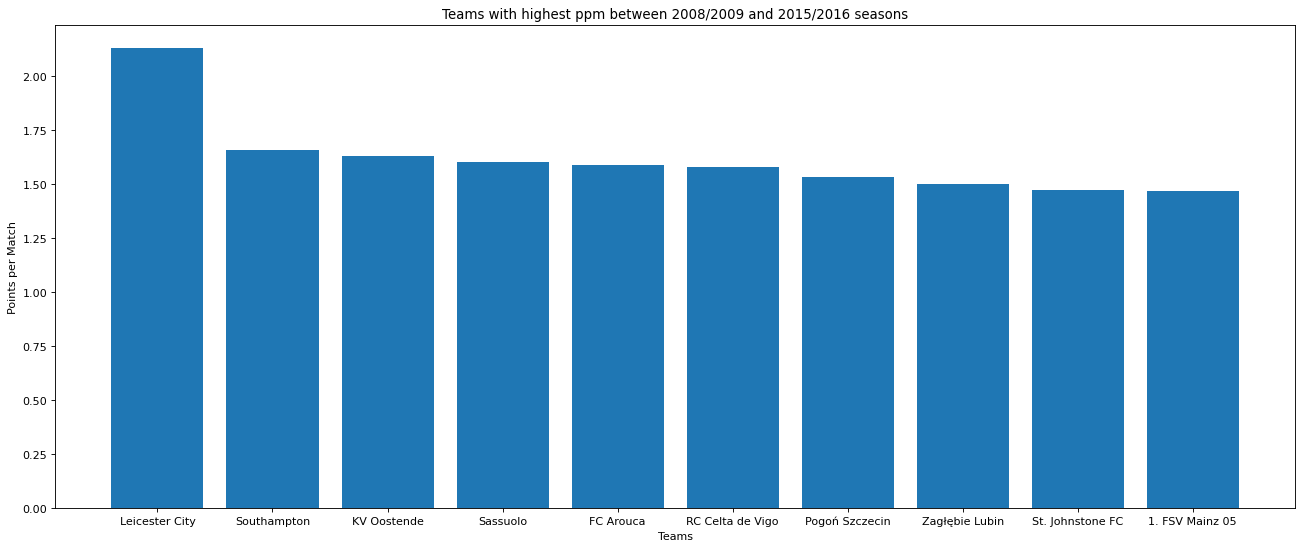

In [215]:
plt.figure(figsize=(20, 8), dpi=80)
plt.bar(s_2016_2008_ppm_team_names,s_2016_2008_ppm.head(10));
plt.title("Teams with highest ppm between 2008/2009 and 2015/2016 seasons");
plt.xlabel("Teams");
plt.ylabel("Points per Match");

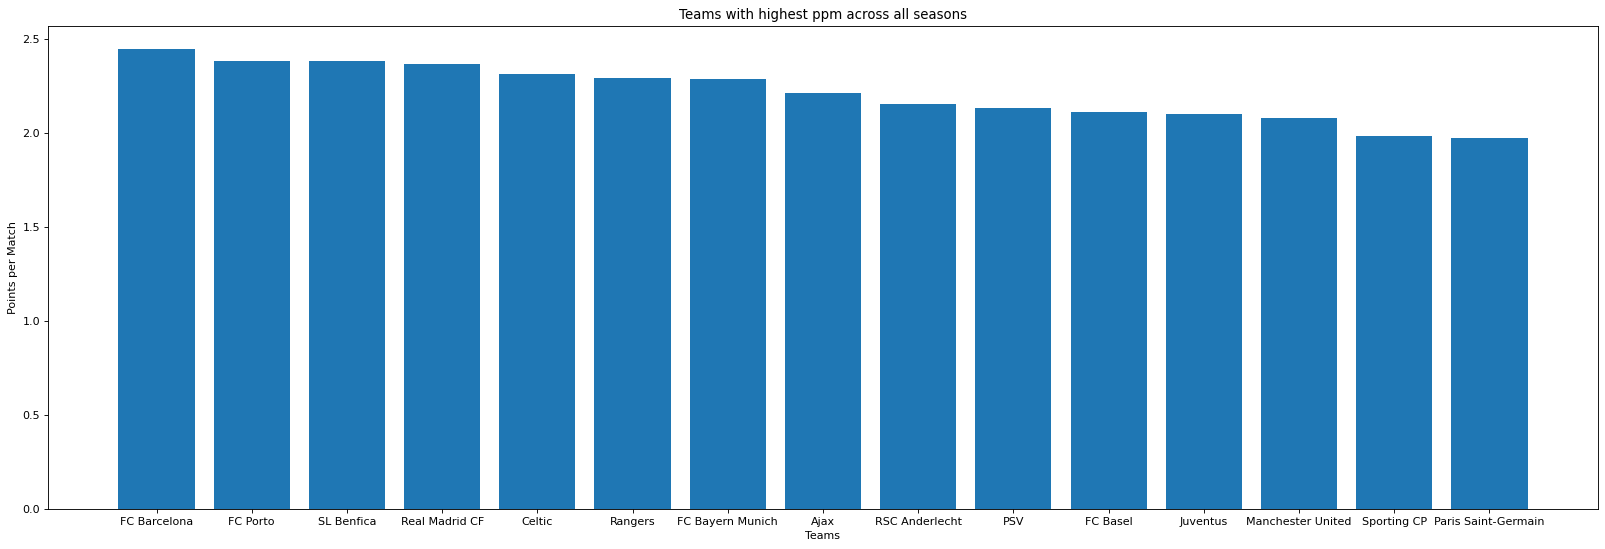

In [216]:
plt.figure(figsize=(25, 8), dpi=80)
plt.bar(ppm_team_names_list,teams_ppm.head(15));
plt.title("Teams with highest ppm across all seasons");
plt.xlabel("Teams");
plt.ylabel("Points per Match");

In [91]:
#code for debugging purposes
df_match.goal.dropna().iloc[13]

'<goal><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>406</event_incident_typefk><elapsed>90</elapsed><player2>36012</player2><subtype>header</subtype><player1>39618</player1><sortorder>2</sortorder><team>8668</team><id>465700</id><n>321</n><type>goal</type><goal_type>n</goal_type></value></goal>'

In [92]:
#code for debugging purposes
goals_data=df_match.goal.dropna().reset_index().iloc[13979]
soup1 = BeautifulSoup(goals_data[1], "html.parser")  
#awaypos=soup.find_all('awaypos')[-1].contents[0]
#homepos=soup.find_all('homepos')[-1].contents[0]
#soup.find('div', class_='audience-info hidden-xs superPageFontColor')

In [93]:
#code for debugging purposes
print(soup1.find_all('subtype'))
soup1.find_all('player1')

[<subtype>header</subtype>, <subtype>bicycle_kick</subtype>, <subtype>shot</subtype>]


[<player1>37482</player1>, <player1>26166</player1>, <player1>30893</player1>]

In [94]:
#code for debugging purposes
soup1

<goal><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>406</event_incident_typefk><coordinates><value>26</value><value>7</value></coordinates><elapsed>56</elapsed><player2>25773</player2><subtype>header</subtype><player1>37482</player1><sortorder>4</sortorder><team>8634</team><id>5452905</id><n>299</n><type>goal</type><goal_type>n</goal_type></value><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>167</event_incident_typefk><coordinates><value>21</value><value>64</value></coordinates><elapsed>63</elapsed><subtype>bicycle_kick</subtype><player1>26166</player1><sortorder>3</sortorder><team>8633</team><id>5453019</id><n>318</n><type>goal</type><goal_type>n</goal_type></value><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>393</event_incident_typefk><coordinates><value>31</value><value>67</value></coordinates><elapsed>85</elapsed><player2>31

In [95]:
#code for debugging purposes
df_match[df_match['goal'].notna()].reset_index().query('home_team_api_id==8634 and away_team_api_id==8633')

,index,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
11138,21577,21578,21518,21518,2008/2009,15,2008-12-13,530343,8634,8633,...,6.50,1.530,3.80,6.000,1.60,3.75,5.75,1.62,3.75,6.00
11494,21933,21934,21518,21518,2009/2010,12,2009-11-29,684766,8634,8633,...,4.33,1.750,3.75,4.200,1.85,3.50,4.00,1.83,3.60,4.20
11881,22320,22321,21518,21518,2010/2011,13,2010-11-29,875704,8634,8633,...,3.50,2.100,3.60,3.500,2.10,3.50,3.30,2.10,3.60,3.30
12499,22939,22940,21518,21518,2011/2012,35,2012-04-21,1051981,8634,8633,...,5.00,1.670,4.30,5.200,1.65,3.75,5.00,1.67,3.75,4.75
12955,23395,23396,21518,21518,2012/2013,7,2012-10-07,1260080,8634,8633,...,4.00,1.900,4.00,4.000,1.95,4.00,3.60,1.85,3.75,4.00
12993,23433,23434,21518,21518,2013/2014,10,2013-10-26,1505908,8634,8633,...,4.20,1.833,4.00,4.333,NaN,NaN,NaN,NaN,NaN,NaN
13564,24004,24005,21518,21518,2014/2015,28,2015-03-22,1778311,8634,8633,...,NaN,1.670,4.50,4.800,NaN,NaN,NaN,NaN,NaN,NaN
13979,24419,24420,21518,21518,2015/2016,31,2016-04-02,2030460,8634,8633,...,NaN,1.600,4.60,5.000,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
#code for debugging purposes
df_player.query('player_api_id==26166')

,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
5629,26166,Karim Benzema,165153,1987-12-19 00:00:00,187.96,174


In [115]:
#calculates player with highest goal subtypes across all seasons
i=0
goal_types_list=[]
scorers_list=[]
for goals in df_match[df_match['goal'].notna()].goal:
    soup1 = BeautifulSoup(goals, "html.parser")
    try:
        goal_types=soup1.find_all('subtype')
        goal_scorer=soup1.find_all('player1')
        v=0
        for types in goal_types:
            type_text=types.get_text()   
            if type_text not in goal_types_list:
                goal_types_list.append(type_text)                
            if type_text == ((('header'))):
                scorer_id=goal_scorer[v].get_text()
                scorer_name=df_player.query('player_api_id=={}'.format(scorer_id)).player_name.iloc[0]
                scorers_list.append(scorer_name)
            v+=1
        i+=1  
    except:
        i+=1
        continue  

In [116]:
goal_types_list

['header',
 'shot',
 'distance',
 'volley',
 'direct_freekick',
 'deflected',
 'loose_ball',
 'saved',
 'bicycle_kick',
 'saved_back_into_play',
 'crossbar',
 'post',
 'missed',
 'indirect freekick',
 'tap_in',
 'backheel',
 'lob']

In [117]:
df_scorers_list=pd.DataFrame(scorers_list)

In [118]:
df_scorers_list.value_counts().head(20)

Cristiano Ronaldo    35
Peter Crouch         26
Fernando Llorente    23
Wayne Rooney         20
Andy Carroll         19
Alberto Gilardino    18
Edin Dzeko           17
Christian Benteke    17
Olivier Giroud       16
Steven Fletcher      16
Gareth Bale          16
Tim Cahill           16
John Terry           16
Kenwyne Jones        15
Aritz Aduriz         15
Frank Lampard        15
Lionel Messi         15
Luis Suarez          14
Emmanuel Adebayor    14
Dirk Kuyt            14
dtype: int64

In [113]:
#calculates highest fouls per player, team and league and highest players fouled
i=0
team_fouls_list=[]
player_foul_list=[]
player_fouled_list=[]
league_fouls_list=[]
team_fouls_list_matches=[]
player_foul_list_matches=[]
league_fouls_list_matches=[]
for fouls in df_match[df_match['foulcommit'].notna()].foulcommit:
    try:      
        soup1 = BeautifulSoup(fouls, "html.parser")
        team_fouls=soup1.find_all('team')
        players_fouls=soup1.find_all('player1')
        players_fouled=soup1.find_all('player2')
        for teams in team_fouls:
            teams_text=teams.get_text()
            Team_Name=df_Team.query('team_api_id=={}'.format(teams_text)).team_long_name.iloc[0]
            team_fouls_list.append(Team_Name)
            league_fouls=df_match[df_match['foulcommit'].notna()].iloc[i].league_id 
            league_fouls_list.append(df_league.query('id=={}'.format(league_fouls)).name.iloc[0])     
        for players in players_fouls:
            players_text=players.get_text()
            foul_name=df_player.query('player_api_id=={}'.format(players_text)).player_name.iloc[0]
            player_foul_list.append(foul_name)              
        for players2 in players_fouled:
            players_text2=players2.get_text()
            fouled_name=df_player.query('player_api_id=={}'.format(players_text2)).player_name.iloc[0]
            player_fouled_list.append(fouled_name)             
        league_fouls_list_matches.append(df_league.query('id=={}'.format(league_fouls)).name.iloc[0])
       
        temp1=df_Team.query('team_api_id=={}'.format(df_match[df_match['foulcommit'].notna()].home_team_api_id.iloc[i])).team_long_name.iloc[0]
        temp2=df_Team.query('team_api_id=={}'.format(df_match[df_match['foulcommit'].notna()].away_team_api_id.iloc[i])).team_long_name.iloc[0]
        team_fouls_list_matches.extend([temp1, temp2])     
        temp3=df_player.query('player_api_id=={}'.format(df_match[df_match['foulcommit'].notna()].home_player_1.iloc[i])).player_name.iloc[0]
        temp4=df_player.query('player_api_id=={}'.format(df_match[df_match['foulcommit'].notna()].home_player_2.iloc[i])).player_name.iloc[0]
        temp5=df_player.query('player_api_id=={}'.format(df_match[df_match['foulcommit'].notna()].home_player_3.iloc[i])).player_name.iloc[0]
        temp6=df_player.query('player_api_id=={}'.format(df_match[df_match['foulcommit'].notna()].home_player_4.iloc[i])).player_name.iloc[0]
        temp7=df_player.query('player_api_id=={}'.format(df_match[df_match['foulcommit'].notna()].home_player_5.iloc[i])).player_name.iloc[0]
        temp8=df_player.query('player_api_id=={}'.format(df_match[df_match['foulcommit'].notna()].home_player_6.iloc[i])).player_name.iloc[0]
        temp9=df_player.query('player_api_id=={}'.format(df_match[df_match['foulcommit'].notna()].home_player_7.iloc[i])).player_name.iloc[0]
        temp10=df_player.query('player_api_id=={}'.format(df_match[df_match['foulcommit'].notna()].home_player_8.iloc[i])).player_name.iloc[0]
        temp11=df_player.query('player_api_id=={}'.format(df_match[df_match['foulcommit'].notna()].home_player_9.iloc[i])).player_name.iloc[0]
        temp12=df_player.query('player_api_id=={}'.format(df_match[df_match['foulcommit'].notna()].home_player_10.iloc[i])).player_name.iloc[0]
        temp13=df_player.query('player_api_id=={}'.format(df_match[df_match['foulcommit'].notna()].home_player_11.iloc[i])).player_name.iloc[0]
        temp14=df_player.query('player_api_id=={}'.format(df_match[df_match['foulcommit'].notna()].away_player_1.iloc[i])).player_name.iloc[0]
        temp15=df_player.query('player_api_id=={}'.format(df_match[df_match['foulcommit'].notna()].away_player_2.iloc[i])).player_name.iloc[0]
        temp16=df_player.query('player_api_id=={}'.format(df_match[df_match['foulcommit'].notna()].away_player_3.iloc[i])).player_name.iloc[0]
        temp17=df_player.query('player_api_id=={}'.format(df_match[df_match['foulcommit'].notna()].away_player_4.iloc[i])).player_name.iloc[0]
        temp18=df_player.query('player_api_id=={}'.format(df_match[df_match['foulcommit'].notna()].away_player_5.iloc[i])).player_name.iloc[0]
        temp19=df_player.query('player_api_id=={}'.format(df_match[df_match['foulcommit'].notna()].away_player_6.iloc[i])).player_name.iloc[0]
        temp20=df_player.query('player_api_id=={}'.format(df_match[df_match['foulcommit'].notna()].away_player_7.iloc[i])).player_name.iloc[0]
        temp21=df_player.query('player_api_id=={}'.format(df_match[df_match['foulcommit'].notna()].away_player_8.iloc[i])).player_name.iloc[0]
        temp22=df_player.query('player_api_id=={}'.format(df_match[df_match['foulcommit'].notna()].away_player_9.iloc[i])).player_name.iloc[0]
        temp23=df_player.query('player_api_id=={}'.format(df_match[df_match['foulcommit'].notna()].away_player_10.iloc[i])).player_name.iloc[0]
        temp24=df_player.query('player_api_id=={}'.format(df_match[df_match['foulcommit'].notna()].away_player_11.iloc[i])).player_name.iloc[0]    
        player_foul_list_matches.extend([temp3,temp4,temp5,temp6,temp7,temp8,temp9,temp10,temp11,temp12,temp13,temp14,temp15,temp16,temp17,temp18,temp19,temp20,temp21,temp22,temp23,temp24])
        i+=1
        print (round(i*100/df_match[df_match['foulcommit'].notna()].shape[0],2),'%')        
        #if i==50:
            #break
    except:
        #if i==50:
            #break
        i+=1
        print ('Error')
        continue

0.01 %
0.01 %
Error
0.03 %
Error
0.04 %
0.05 %
0.06 %
0.06 %
0.07 %
0.08 %
0.08 %
0.09 %
0.1 %
0.11 %
Error
0.12 %
Error
0.13 %
0.14 %
0.15 %
Error
0.16 %
0.17 %
0.18 %
0.18 %
0.19 %
0.2 %
0.2 %
0.21 %
0.22 %
Error
0.23 %
0.24 %
0.25 %
0.25 %
Error
0.27 %
0.27 %
0.28 %
0.29 %
0.3 %
0.3 %
0.31 %
0.32 %
0.32 %
0.33 %
0.34 %
Error
0.35 %
0.36 %
0.37 %
0.37 %
0.38 %
0.39 %
0.39 %
Error
Error
0.41 %
0.42 %
0.43 %
0.44 %
0.44 %
0.45 %
0.46 %
0.46 %
0.47 %
0.48 %
0.49 %
0.49 %
Error
0.51 %
0.51 %
0.52 %
0.53 %
0.53 %
0.54 %
0.55 %
0.56 %
0.56 %
0.57 %
Error
0.58 %
0.59 %
0.6 %
0.6 %
0.61 %
0.62 %
0.63 %
0.63 %
0.64 %
0.65 %
0.65 %
0.66 %
0.67 %
0.68 %
0.68 %
0.69 %
0.7 %
0.7 %
0.71 %
0.72 %
0.72 %
0.73 %
0.74 %
0.75 %
0.75 %
0.76 %
0.77 %
0.77 %
Error
0.79 %
0.79 %
Error
0.81 %
Error
0.82 %
0.83 %
0.84 %
0.84 %
0.85 %
0.86 %
0.87 %
0.87 %
Error
0.89 %
0.89 %
0.9 %
0.91 %
0.91 %
0.92 %
0.93 %
0.94 %
0.94 %
0.95 %
0.96 %
0.96 %
0.97 %
0.98 %
0.98 %
0.99 %
1.0 %
1.01 %
1.01 %
1.02 %
1.03 %
1.03 

8.45 %
8.46 %
8.47 %
8.48 %
8.48 %
8.49 %
8.5 %
Error
8.51 %
8.52 %
8.53 %
8.53 %
8.54 %
8.55 %
Error
8.56 %
8.57 %
8.57 %
8.58 %
8.59 %
8.6 %
8.6 %
8.61 %
8.62 %
8.62 %
Error
8.64 %
8.64 %
8.65 %
8.66 %
8.67 %
Error
8.68 %
8.69 %
8.69 %
8.7 %
8.71 %
Error
8.72 %
8.73 %
8.74 %
8.74 %
8.75 %
8.76 %
Error
8.77 %
8.78 %
Error
8.79 %
Error
8.81 %
8.81 %
8.82 %
8.83 %
8.83 %
8.84 %
8.85 %
8.86 %
8.86 %
8.87 %
8.88 %
8.88 %
8.89 %
8.9 %
8.9 %
8.91 %
Error
8.93 %
8.93 %
8.94 %
8.95 %
8.95 %
8.96 %
8.97 %
8.98 %
8.98 %
8.99 %
Error
9.0 %
9.01 %
9.02 %
9.02 %
9.03 %
9.04 %
9.05 %
9.05 %
Error
9.07 %
9.07 %
9.08 %
9.09 %
9.09 %
9.1 %
9.11 %
9.12 %
9.12 %
9.13 %
9.14 %
Error
9.15 %
9.16 %
9.17 %
9.17 %
9.18 %
9.19 %
9.19 %
9.2 %
9.21 %
9.21 %
9.22 %
9.23 %
9.24 %
9.24 %
9.25 %
9.26 %
9.26 %
9.27 %
9.28 %
9.28 %
9.29 %
9.3 %
9.31 %
9.31 %
9.32 %
9.33 %
9.33 %
9.34 %
9.35 %
9.35 %
9.36 %
9.37 %
9.38 %
9.38 %
9.39 %
9.4 %
9.4 %
9.41 %
9.42 %
9.43 %
9.43 %
9.44 %
9.45 %
9.45 %
9.46 %
9.47 %
9.47 %
9.

16.02 %
16.03 %
16.04 %
16.04 %
16.05 %
Error
Error
16.07 %
16.08 %
16.09 %
16.09 %
16.1 %
16.11 %
Error
16.12 %
16.13 %
16.14 %
16.14 %
16.15 %
Error
16.16 %
16.17 %
16.18 %
16.18 %
16.19 %
16.2 %
16.21 %
Error
16.22 %
16.23 %
16.23 %
16.24 %
16.25 %
16.26 %
16.26 %
16.27 %
16.28 %
16.28 %
16.29 %
Error
16.3 %
16.31 %
16.32 %
16.33 %
16.33 %
16.34 %
16.35 %
16.35 %
16.36 %
16.37 %
16.37 %
16.38 %
16.39 %
16.4 %
16.4 %
16.41 %
16.42 %
Error
16.43 %
16.44 %
16.45 %
16.45 %
16.46 %
Error
16.47 %
16.48 %
16.49 %
16.49 %
16.5 %
16.51 %
16.52 %
16.52 %
Error
16.54 %
Error
16.55 %
16.56 %
16.56 %
16.57 %
16.58 %
16.59 %
16.59 %
16.6 %
16.61 %
Error
16.62 %
16.63 %
16.64 %
16.64 %
16.65 %
16.66 %
16.66 %
16.67 %
16.68 %
16.68 %
16.69 %
16.7 %
16.71 %
16.71 %
16.72 %
16.73 %
16.73 %
16.74 %
16.75 %
16.75 %
Error
16.77 %
16.78 %
16.78 %
16.79 %
16.8 %
16.8 %
16.81 %
16.82 %
16.82 %
Error
16.84 %
16.85 %
16.85 %
16.86 %
16.87 %
16.87 %
16.88 %
16.89 %
Error
16.9 %
16.91 %
Error
16.92 %
16.93 %
1

23.44 %
Error
23.45 %
23.46 %
23.46 %
23.47 %
23.48 %
23.49 %
23.49 %
23.5 %
23.51 %
23.51 %
23.52 %
23.53 %
23.54 %
23.54 %
23.55 %
23.56 %
23.56 %
23.57 %
23.58 %
23.58 %
23.59 %
23.6 %
23.61 %
23.61 %
23.62 %
23.63 %
Error
23.64 %
23.65 %
23.65 %
23.66 %
23.67 %
23.68 %
23.68 %
23.69 %
23.7 %
23.7 %
23.71 %
23.72 %
23.73 %
23.73 %
Error
23.75 %
23.75 %
23.76 %
23.77 %
23.77 %
23.78 %
23.79 %
23.8 %
23.8 %
23.81 %
23.82 %
23.82 %
23.83 %
23.84 %
23.84 %
23.85 %
23.86 %
23.87 %
23.87 %
23.88 %
23.89 %
23.89 %
23.9 %
23.91 %
23.92 %
23.92 %
23.93 %
23.94 %
23.94 %
23.95 %
23.96 %
23.96 %
23.97 %
23.98 %
23.99 %
23.99 %
24.0 %
24.01 %
24.01 %
24.02 %
24.03 %
24.03 %
24.04 %
24.05 %
24.06 %
24.06 %
24.07 %
24.08 %
24.08 %
24.09 %
24.1 %
24.1 %
24.11 %
24.12 %
24.13 %
24.13 %
24.14 %
24.15 %
24.15 %
24.16 %
24.17 %
24.18 %
24.18 %
24.19 %
24.2 %
24.2 %
24.21 %
24.22 %
24.22 %
24.23 %
24.24 %
24.25 %
24.25 %
24.26 %
24.27 %
24.27 %
24.28 %
24.29 %
24.29 %
24.3 %
24.31 %
24.32 %
24.32 %
24.

30.8 %
30.81 %
30.82 %
30.82 %
30.83 %
30.84 %
30.84 %
30.85 %
30.86 %
30.86 %
30.87 %
30.88 %
30.89 %
30.89 %
30.9 %
30.91 %
Error
30.92 %
30.93 %
30.93 %
30.94 %
30.95 %
30.96 %
30.96 %
30.97 %
30.98 %
30.98 %
Error
31.0 %
31.01 %
31.01 %
Error
31.03 %
31.03 %
31.04 %
31.05 %
31.05 %
31.06 %
31.07 %
31.08 %
31.08 %
31.09 %
31.1 %
31.1 %
31.11 %
31.12 %
31.12 %
31.13 %
31.14 %
31.15 %
31.15 %
31.16 %
Error
31.17 %
Error
31.19 %
Error
31.2 %
Error
Error
31.22 %
Error
31.24 %
31.24 %
31.25 %
Error
31.27 %
Error
Error
31.29 %
31.29 %
31.3 %
Error
31.31 %
Error
Error
31.34 %
31.34 %
31.35 %
31.36 %
Error
31.37 %
Error
Error
31.39 %
31.4 %
31.41 %
31.41 %
31.42 %
31.43 %
Error
31.44 %
31.45 %
31.46 %
Error
31.47 %
31.48 %
31.48 %
31.49 %
31.5 %
31.5 %
31.51 %
31.52 %
Error
31.53 %
31.54 %
31.55 %
31.55 %
31.56 %
31.57 %
31.57 %
31.58 %
Error
31.6 %
31.6 %
31.61 %
31.62 %
31.62 %
31.63 %
31.64 %
31.65 %
31.65 %
31.66 %
31.67 %
31.67 %
31.68 %
Error
31.69 %
31.7 %
31.71 %
31.72 %
31.72 %
31.

38.4 %
38.4 %
38.41 %
38.42 %
38.43 %
38.43 %
38.44 %
Error
38.45 %
38.46 %
38.47 %
38.48 %
38.48 %
38.49 %
38.5 %
38.5 %
38.51 %
38.52 %
38.52 %
38.53 %
38.54 %
Error
38.55 %
38.56 %
38.57 %
38.57 %
38.58 %
38.59 %
38.59 %
38.6 %
38.61 %
38.62 %
38.62 %
38.63 %
38.64 %
38.64 %
38.65 %
38.66 %
Error
Error
38.68 %
38.69 %
38.69 %
38.7 %
38.71 %
38.71 %
38.72 %
38.73 %
38.74 %
38.74 %
38.75 %
Error
38.76 %
38.77 %
38.78 %
38.78 %
38.79 %
38.8 %
38.81 %
38.81 %
38.82 %
38.83 %
38.83 %
38.84 %
38.85 %
38.85 %
38.86 %
38.87 %
38.88 %
38.88 %
38.89 %
38.9 %
38.9 %
38.91 %
38.92 %
38.93 %
38.93 %
38.94 %
38.95 %
38.95 %
38.96 %
38.97 %
38.97 %
38.98 %
38.99 %
39.0 %
39.0 %
39.01 %
39.02 %
39.02 %
39.03 %
39.04 %
39.04 %
39.05 %
39.06 %
39.07 %
39.07 %
39.08 %
39.09 %
39.09 %
39.1 %
39.11 %
39.12 %
39.12 %
39.13 %
39.14 %
39.14 %
39.15 %
39.16 %
39.16 %
39.17 %
39.18 %
39.19 %
39.19 %
39.2 %
39.21 %
39.21 %
39.22 %
Error
39.23 %
39.24 %
39.25 %
39.26 %
39.26 %
39.27 %
39.28 %
39.28 %
39.29 %
3

45.73 %
45.74 %
45.75 %
45.76 %
45.76 %
45.77 %
45.78 %
45.78 %
45.79 %
45.8 %
45.8 %
45.81 %
45.82 %
45.83 %
45.83 %
45.84 %
45.85 %
45.85 %
45.86 %
45.87 %
45.87 %
45.88 %
45.89 %
45.9 %
45.9 %
45.91 %
45.92 %
45.92 %
45.93 %
45.94 %
45.94 %
45.95 %
45.96 %
45.97 %
45.97 %
45.98 %
45.99 %
45.99 %
46.0 %
46.01 %
46.02 %
46.02 %
46.03 %
46.04 %
46.04 %
46.05 %
46.06 %
46.06 %
46.07 %
46.08 %
46.09 %
46.09 %
46.1 %
46.11 %
46.11 %
46.12 %
46.13 %
46.13 %
46.14 %
46.15 %
46.16 %
46.16 %
46.17 %
46.18 %
46.18 %
46.19 %
46.2 %
46.21 %
46.21 %
46.22 %
46.23 %
46.23 %
46.24 %
46.25 %
46.25 %
46.26 %
46.27 %
46.28 %
46.28 %
46.29 %
46.3 %
46.3 %
46.31 %
46.32 %
46.32 %
46.33 %
46.34 %
46.35 %
46.35 %
46.36 %
46.37 %
46.37 %
46.38 %
46.39 %
46.4 %
46.4 %
46.41 %
46.42 %
46.42 %
46.43 %
46.44 %
46.44 %
46.45 %
46.46 %
46.47 %
46.47 %
46.48 %
46.49 %
46.49 %
46.5 %
46.51 %
46.51 %
46.52 %
46.53 %
46.54 %
46.54 %
46.55 %
46.56 %
46.56 %
46.57 %
46.58 %
46.59 %
46.59 %
46.6 %
46.61 %
46.61 %
46.62

53.09 %
Error
53.11 %
53.11 %
53.12 %
53.13 %
53.13 %
53.14 %
53.15 %
53.15 %
53.16 %
Error
53.18 %
53.18 %
53.19 %
53.2 %
53.2 %
Error
53.22 %
Error
Error
53.24 %
53.25 %
53.25 %
53.26 %
53.27 %
Error
Error
53.29 %
53.3 %
53.3 %
53.31 %
53.32 %
Error
Error
53.34 %
53.34 %
Error
53.36 %
53.37 %
Error
53.38 %
Error
53.39 %
53.4 %
53.41 %
53.41 %
53.42 %
53.43 %
53.44 %
Error
53.45 %
53.46 %
53.46 %
Error
53.48 %
53.49 %
53.49 %
53.5 %
53.51 %
53.51 %
53.52 %
Error
Error
53.54 %
53.55 %
Error
53.56 %
53.57 %
53.58 %
53.58 %
Error
53.6 %
53.6 %
53.61 %
53.62 %
53.63 %
53.63 %
53.64 %
53.65 %
53.65 %
53.66 %
53.67 %
53.68 %
53.68 %
53.69 %
53.7 %
53.7 %
53.71 %
Error
53.72 %
53.73 %
53.74 %
53.75 %
53.75 %
53.76 %
Error
53.77 %
53.78 %
Error
53.79 %
53.8 %
53.81 %
Error
53.82 %
53.83 %
53.84 %
53.84 %
Error
53.86 %
Error
Error
Error
53.89 %
53.89 %
53.9 %
53.91 %
53.91 %
53.92 %
53.93 %
53.94 %
53.94 %
53.95 %
53.96 %
53.96 %
53.97 %
53.98 %
53.98 %
53.99 %
54.0 %
54.01 %
54.01 %
54.02 %
5

60.7 %
Error
60.72 %
60.72 %
60.73 %
60.74 %
60.74 %
Error
60.76 %
60.77 %
60.77 %
60.78 %
60.79 %
60.79 %
60.8 %
60.81 %
60.81 %
60.82 %
60.83 %
60.84 %
60.84 %
Error
60.86 %
Error
60.87 %
Error
60.88 %
60.89 %
60.9 %
Error
60.91 %
60.92 %
60.93 %
60.93 %
60.94 %
60.95 %
60.96 %
60.96 %
60.97 %
60.98 %
60.98 %
60.99 %
61.0 %
61.0 %
Error
61.02 %
61.03 %
61.03 %
61.04 %
61.05 %
61.05 %
61.06 %
61.07 %
61.07 %
Error
61.09 %
61.1 %
61.1 %
61.11 %
61.12 %
61.12 %
61.13 %
61.14 %
Error
61.15 %
61.16 %
61.17 %
61.17 %
61.18 %
Error
Error
61.2 %
61.21 %
61.22 %
61.22 %
61.23 %
61.24 %
61.24 %
61.25 %
Error
Error
61.27 %
61.28 %
61.29 %
61.29 %
61.3 %
61.31 %
61.31 %
Error
Error
61.34 %
61.34 %
61.35 %
61.36 %
Error
61.37 %
61.38 %
61.38 %
Error
61.4 %
61.41 %
61.41 %
61.42 %
61.43 %
61.43 %
61.44 %
61.45 %
61.45 %
61.46 %
61.47 %
61.48 %
61.48 %
Error
Error
Error
61.51 %
61.52 %
61.52 %
61.53 %
Error
61.55 %
Error
61.56 %
61.57 %
61.57 %
61.58 %
61.59 %
61.6 %
61.6 %
61.61 %
Error
Error
61.6

68.16 %
68.17 %
68.18 %
68.19 %
68.19 %
68.2 %
Error
68.21 %
68.22 %
68.23 %
68.24 %
68.24 %
68.25 %
68.26 %
68.26 %
68.27 %
Error
68.28 %
68.29 %
68.3 %
68.31 %
68.31 %
68.32 %
68.33 %
68.33 %
68.34 %
68.35 %
68.35 %
68.36 %
68.37 %
68.38 %
68.38 %
68.39 %
68.4 %
68.4 %
68.41 %
68.42 %
68.43 %
68.43 %
68.44 %
68.45 %
68.45 %
68.46 %
68.47 %
68.47 %
68.48 %
68.49 %
68.5 %
68.5 %
68.51 %
68.52 %
68.52 %
68.53 %
68.54 %
68.54 %
68.55 %
68.56 %
68.57 %
68.57 %
68.58 %
68.59 %
68.59 %
68.6 %
68.61 %
Error
68.62 %
68.63 %
68.64 %
68.64 %
68.65 %
68.66 %
68.66 %
68.67 %
68.68 %
68.69 %
68.69 %
68.7 %
Error
68.71 %
68.72 %
Error
68.73 %
Error
68.75 %
Error
68.76 %
68.77 %
68.78 %
68.78 %
68.79 %
68.8 %
68.8 %
68.81 %
68.82 %
68.83 %
68.83 %
Error
68.85 %
68.85 %
68.86 %
68.87 %
68.88 %
68.88 %
68.89 %
68.9 %
68.9 %
68.91 %
Error
68.92 %
Error
Error
68.95 %
68.95 %
68.96 %
68.97 %
68.97 %
68.98 %
68.99 %
Error
69.0 %
Error
69.02 %
69.02 %
69.03 %
69.04 %
69.04 %
69.05 %
Error
69.07 %
Error
69.

Error
Error
75.72 %
Error
75.73 %
Error
75.75 %
75.75 %
75.76 %
75.77 %
Error
75.78 %
75.79 %
Error
75.8 %
75.81 %
75.82 %
Error
Error
75.84 %
75.85 %
75.85 %
75.86 %
75.87 %
75.87 %
75.88 %
Error
Error
75.9 %
75.91 %
75.92 %
75.92 %
75.93 %
75.94 %
75.94 %
75.95 %
Error
75.97 %
75.97 %
75.98 %
75.99 %
75.99 %
76.0 %
Error
76.01 %
76.02 %
76.03 %
76.04 %
76.04 %
76.05 %
76.06 %
76.06 %
Error
Error
76.08 %
76.09 %
Error
76.11 %
76.11 %
Error
76.13 %
76.13 %
76.14 %
Error
76.16 %
76.16 %
76.17 %
76.18 %
Error
76.19 %
Error
76.2 %
76.21 %
76.22 %
76.23 %
Error
76.24 %
76.25 %
76.25 %
Error
76.27 %
Error
76.28 %
76.29 %
Error
76.3 %
76.31 %
76.32 %
76.32 %
76.33 %
Error
Error
76.35 %
76.36 %
76.37 %
76.37 %
Error
Error
76.39 %
76.4 %
76.41 %
76.42 %
Error
76.43 %
76.44 %
Error
Error
76.46 %
76.46 %
76.47 %
Error
76.49 %
76.49 %
Error
76.51 %
Error
76.52 %
Error
Error
76.54 %
Error
76.56 %
Error
76.57 %
76.58 %
76.58 %
76.59 %
Error
Error
Error
76.62 %
76.63 %
76.63 %
76.64 %
76.65 %
76.65 

83.6 %
Error
83.61 %
83.62 %
83.63 %
83.63 %
83.64 %
83.65 %
83.65 %
83.66 %
83.67 %
83.67 %
Error
83.69 %
83.7 %
83.7 %
83.71 %
83.72 %
83.72 %
83.73 %
83.74 %
83.74 %
Error
83.76 %
83.77 %
Error
83.78 %
83.79 %
83.79 %
83.8 %
83.81 %
83.82 %
83.82 %
Error
Error
83.84 %
83.85 %
83.86 %
83.86 %
Error
83.88 %
83.89 %
Error
83.9 %
83.91 %
83.91 %
83.92 %
83.93 %
Error
83.94 %
83.95 %
83.96 %
Error
83.97 %
83.98 %
83.98 %
83.99 %
84.0 %
84.01 %
84.01 %
84.02 %
Error
84.03 %
84.04 %
84.05 %
84.05 %
84.06 %
84.07 %
84.08 %
84.08 %
84.09 %
84.1 %
84.1 %
84.11 %
Error
84.12 %
84.13 %
84.14 %
84.15 %
84.15 %
84.16 %
84.17 %
Error
84.18 %
84.19 %
Error
84.2 %
84.21 %
84.22 %
84.22 %
84.23 %
84.24 %
84.24 %
84.25 %
84.26 %
Error
84.27 %
84.28 %
84.29 %
84.29 %
84.3 %
84.31 %
84.31 %
Error
84.33 %
84.34 %
Error
84.35 %
84.36 %
84.36 %
84.37 %
84.38 %
84.38 %
84.39 %
84.4 %
84.41 %
Error
84.42 %
84.43 %
84.43 %
Error
84.45 %
84.46 %
84.46 %
84.47 %
84.48 %
84.48 %
Error
84.5 %
84.5 %
84.51 %
84.52

91.0 %
91.0 %
91.01 %
91.02 %
91.02 %
91.03 %
91.04 %
91.05 %
91.05 %
91.06 %
91.07 %
91.07 %
91.08 %
91.09 %
91.1 %
91.1 %
91.11 %
91.12 %
91.12 %
91.13 %
91.14 %
91.14 %
91.15 %
91.16 %
91.17 %
91.17 %
91.18 %
91.19 %
91.19 %
91.2 %
91.21 %
91.21 %
91.22 %
91.23 %
91.24 %
91.24 %
91.25 %
91.26 %
91.26 %
91.27 %
91.28 %
91.29 %
91.29 %
91.3 %
91.31 %
91.31 %
91.32 %
91.33 %
91.33 %
91.34 %
91.35 %
91.36 %
91.36 %
91.37 %
91.38 %
91.38 %
91.39 %
91.4 %
91.4 %
91.41 %
Error
91.43 %
91.43 %
91.44 %
91.45 %
91.45 %
91.46 %
91.47 %
91.47 %
91.48 %
91.49 %
91.5 %
91.5 %
91.51 %
91.52 %
91.52 %
91.53 %
91.54 %
91.55 %
91.55 %
91.56 %
91.57 %
91.57 %
91.58 %
91.59 %
91.59 %
91.6 %
91.61 %
91.62 %
91.62 %
91.63 %
91.64 %
91.64 %
91.65 %
91.66 %
91.66 %
91.67 %
91.68 %
91.69 %
91.69 %
91.7 %
91.71 %
91.71 %
91.72 %
91.73 %
91.74 %
91.74 %
91.75 %
91.76 %
91.76 %
91.77 %
91.78 %
91.78 %
91.79 %
91.8 %
91.81 %
91.81 %
91.82 %
91.83 %
91.83 %
91.84 %
91.85 %
91.85 %
91.86 %
91.87 %
91.88 %
91.88 %

98.45 %
98.46 %
Error
98.47 %
98.48 %
98.49 %
98.49 %
98.5 %
98.51 %
98.52 %
98.52 %
98.53 %
Error
98.54 %
98.55 %
98.56 %
98.57 %
98.57 %
98.58 %
98.59 %
98.59 %
98.6 %
98.61 %
98.61 %
98.62 %
Error
98.64 %
98.64 %
98.65 %
98.66 %
98.66 %
98.67 %
98.68 %
98.68 %
Error
98.7 %
98.71 %
98.71 %
98.72 %
98.73 %
98.73 %
98.74 %
98.75 %
98.76 %
Error
98.77 %
98.78 %
98.78 %
98.79 %
98.8 %
98.8 %
Error
Error
Error
Error
98.84 %
98.85 %
Error
98.86 %
98.87 %
98.87 %
Error
98.89 %
98.9 %
98.9 %
98.91 %
98.92 %
98.92 %
98.93 %
98.94 %
98.94 %
98.95 %
98.96 %
98.97 %
98.97 %
98.98 %
98.99 %
98.99 %
99.0 %
99.01 %
Error
99.02 %
Error
99.04 %
99.04 %
99.05 %
99.06 %
99.06 %
99.07 %
99.08 %
99.09 %
99.09 %
Error
99.11 %
99.11 %
99.12 %
99.13 %
99.13 %
99.14 %
99.15 %
99.16 %
99.16 %
99.17 %
Error
99.18 %
99.19 %
99.2 %
99.21 %
99.21 %
99.22 %
99.23 %
99.23 %
Error
99.25 %
99.25 %
99.26 %
99.27 %
99.28 %
Error
99.29 %
99.3 %
99.3 %
99.31 %
99.32 %
99.32 %
99.33 %
Error
99.35 %
99.35 %
99.36 %
99.37 %

In [123]:
df_team_fouls_list=pd.DataFrame(team_fouls_list)
df_player_foul_list=pd.DataFrame(player_foul_list)
df_player_fouled_list=pd.DataFrame(player_fouled_list)
df_league_fouls_list=pd.DataFrame(league_fouls_list)
df_team_fouls_list_matches=pd.DataFrame(team_fouls_list_matches)
df_league_fouls_list_matches=pd.DataFrame(league_fouls_list_matches)
df_player_foul_list_matches=pd.DataFrame(player_foul_list_matches)

In [124]:
df_team_fouls_list_VC=df_team_fouls_list.value_counts()
df_player_foul_list_VC=df_player_foul_list.value_counts()
df_player_fouled_list_VC=df_player_fouled_list.value_counts()
df_league_fouls_list_VC=df_league_fouls_list.value_counts()
df_team_fouls_list_matches_VC=df_team_fouls_list_matches.value_counts()
df_league_fouls_list_matches_VC=df_league_fouls_list_matches.value_counts()
df_player_foul_list_matches_VC=df_player_foul_list_matches.value_counts()

In [125]:
df_team_fouls_list_VC=pd.DataFrame(df_team_fouls_list_VC)
df_player_foul_list_VC=pd.DataFrame(df_player_foul_list_VC)
df_player_fouled_list_VC=pd.DataFrame(df_player_fouled_list_VC)
df_league_fouls_list_VC=pd.DataFrame(df_league_fouls_list_VC)
df_team_fouls_list_matches_VC=pd.DataFrame(df_team_fouls_list_matches_VC)
df_league_fouls_list_matches_VC=pd.DataFrame(df_league_fouls_list_matches_VC)
df_player_foul_list_matches_VC=pd.DataFrame(df_player_foul_list_matches_VC)

In [126]:
df_team_fouls_list_VC.columns=(['count_fouls'])
df_player_foul_list_VC.columns=(['count_fouls'])
df_player_fouled_list_VC.columns=(['count_fouls'])
df_league_fouls_list_VC.columns=(['count_fouls'])
df_team_fouls_list_matches_VC.columns=(['count_matches'])
df_league_fouls_list_matches_VC.columns=(['count_matches'])
df_player_foul_list_matches_VC.columns=(['count_matches'])

In [127]:
df_team_fouls_list_Merged = df_team_fouls_list_VC.merge(df_team_fouls_list_matches_VC,left_index=True,right_index=True, how='outer')
df_player_foul_list_Merged = df_player_foul_list_VC.merge(df_player_foul_list_matches_VC,left_index=True,right_index=True, how='outer')
df_player_fouled_list_Merged = df_player_fouled_list_VC.merge(df_player_foul_list_matches_VC,left_index=True,right_index=True, how='outer')
df_league_fouls_list_Merged = df_league_fouls_list_VC.merge(df_league_fouls_list_matches_VC,left_index=True,right_index=True, how='outer')

In [128]:
df_team_fouls_list_Merged['fouls_per_match']=df_team_fouls_list_Merged.count_fouls/df_team_fouls_list_Merged.count_matches
df_player_foul_list_Merged['fouls_per_match']=df_player_foul_list_Merged.count_fouls/df_player_foul_list_Merged.count_matches
df_player_fouled_list_Merged['fouls_per_match']=df_player_fouled_list_Merged.count_fouls/df_player_fouled_list_Merged.count_matches
df_league_fouls_list_Merged['fouls_per_match']=df_league_fouls_list_Merged.count_fouls/df_league_fouls_list_Merged.count_matches

In [129]:
#df_league_fouls_list_Merged.sort_values(by=['fouls_per_match'],ascending=False)
#df_player_foul_list_Merged.sort_values(by=['fouls_per_match'],ascending=False)
#df_player_fouled_list_Merged.sort_values(by=['fouls_per_match'],ascending=False)
#df_team_fouls_list_Merged.sort_values(by=['fouls_per_match'],ascending=False)

In [130]:
#players with highest foul per match rating (must have played at least 150 matches)
df_player_foul_list_Merged.sort_values(by=['fouls_per_match'],ascending=False).query('count_matches>=150').head(30)

,count_fouls,count_matches,fouls_per_match
0,,,
Marouane Fellaini,490.0,166.0,2.951807
Lucas Leiva,339.0,156.0,2.173077
Lee Cattermole,318.0,171.0,1.859649
Gareth Barry,401.0,237.0,1.691983
Alex Song,270.0,161.0,1.677019
Peter Crouch,281.0,181.0,1.552486
Fernando Torres,240.0,157.0,1.528662
Antonio Valencia,246.0,164.0,1.500000
Mikel Arteta,232.0,155.0,1.496774


In [131]:
#leagues with highest foul per match rating (must have at least 1520 matches with data available)
df_league_fouls_list_Merged.sort_values(by=['fouls_per_match'],ascending=False).query('count_matches>=1520')

,count_fouls,count_matches,fouls_per_match
0,,,
England Premier League,67150,3093.0,21.710314
Italy Serie A,44714,2725.0,16.408807
Spain LIGA BBVA,44254,2893.0,15.296924
Germany 1. Bundesliga,33299,2378.0,14.002944
France Ligue 1,20481,1683.0,12.169340


In [134]:
#teams with highest foul per match rating (must have played at least 150 matches)
df_team_fouls_list_Merged.sort_values(by=['fouls_per_match'],ascending=False).query('count_matches>=150').head(30)

,count_fouls,count_matches,fouls_per_match
0,,,
West Ham United,3012.0,243.0,12.395062
West Bromwich Albion,2905.0,236.0,12.309322
Sunderland,3353.0,274.0,12.237226
Aston Villa,3409.0,279.0,12.218638
Wigan Athletic,2223.0,182.0,12.214286
Stoke City,3615.0,296.0,12.212838
Manchester City,3427.0,284.0,12.066901
Liverpool,3290.0,280.0,11.750000
Newcastle United,2966.0,256.0,11.585938


In [133]:
#most fouled players per match (must have played at least 150 matches)
df_player_fouled_list_Merged.sort_values(by=['fouls_per_match'],ascending=False).query('count_matches>=150').head(30)

,count_fouls,count_matches,fouls_per_match
0,,,
Luis Suarez,348.0,167.0,2.083832
Ashley Young,369.0,180.0,2.050000
Eden Hazard,322.0,171.0,1.883041
Fernando Torres,268.0,157.0,1.707006
Cristiano Ronaldo,402.0,239.0,1.682008
Lionel Messi,370.0,220.0,1.681818
Mikel Arteta,246.0,155.0,1.587097
Luca Toni,237.0,150.0,1.580000
Andres Iniesta,263.0,169.0,1.556213
